In [1]:
import torch

# Limit to fraction of total GPU memory
torch.cuda.set_per_process_memory_fraction(0.5, device=0)

## Small processed data

### Load data for prediction

In [2]:
%load_ext autoreload
%autoreload 2
from alphagenome_pytorch import SpliceDataset

# Path to test data
test_data_dir = '/home/elek/sds/sd17d003/Anamaria/splicevo/data_new/splits_adult_50kb/mouse_human/test/'

target_length = 10240  # 10240 49152
max_donor_sites = 20
max_acceptor_sites = 20

species_mapping = {
    'human': 0,
    'mouse': 1
}

test_dataset = SpliceDataset(
    data_dir=test_data_dir,
    target_length=target_length,
    max_donor_sites=max_donor_sites,
    max_acceptor_sites=max_acceptor_sites,
    species_mapping=species_mapping
)

2026-02-20 10:42:59.300101: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-20 10:42:59.340532: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loaded dataset from /home/elek/sds/sd17d003/Anamaria/splicevo/data_new/splits_adult_50kb/mouse_human/test/


In [3]:
next(iter(test_dataset))

{'dna': tensor([3, 0, 1,  ..., 2, 0, 2]),
 'organism_index': tensor(0),
 'splice_donor_idx': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'splice_acceptor_idx': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'num_donors': tensor(0),
 'num_acceptors': tensor(0),
 'splice_labels': tensor([4, 4, 4,  ..., 4, 4, 4]),
 'splice_usage_target': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'conditions_mask': tensor([ 0,  4, 10, 11, 13, 16, 17, 21, 22, 23, 25, 26, 27, 32, 36, 37])}

In [4]:
import os
import pandas as pd

meta_csv_fn = os.path.join(test_data_dir, 'metadata.csv')
metadata_csv = pd.read_csv(meta_csv_fn)
metadata_csv

,chromosome,gene_id,genome_id,n_acceptor_sites,n_donor_sites,strand,window_end,window_start,species_id
0,11,hum.10118,human_GRCh37,0,1,+,26403869,26353869,0
1,11,hum.10118,human_GRCh37,3,4,+,26503869,26453869,0
2,11,hum.10118,human_GRCh37,8,8,+,26553869,26503869,0
3,11,hum.10118,human_GRCh37,12,12,+,26603869,26553869,0
4,11,hum.10118,human_GRCh37,8,8,+,26653869,26603869,0
...,...,...,...,...,...,...,...,...,...
2325,4,mou.33629,mouse_GRCm38,11,8,-,156293603,156243603,1
2326,4,mou.33613,mouse_GRCm38,0,7,+,156101319,156051319,1
2327,4,mou.33613,mouse_GRCm38,390,388,+,156151319,156101319,1
2328,4,mou.33591,mouse_GRCm38,701,704,+,155853096,155803096,1


In [5]:
import json

meta_fn = os.path.join(test_data_dir, 'metadata.json')
with open(meta_fn) as f:
    metadata = json.load(f)

species_conds = metadata['species_condition_mapping']

for org, cond in species_conds.items():
    print(f"Condition for {org}:")
    print([metadata['usage_conditions'][cond_idx] for cond_idx in cond])

Condition for human:
['Brain_10', 'Brain_14', 'Cerebellum_15', 'Heart_10', 'Heart_12', 'Kidney_10', 'Kidney_11', 'Liver_10', 'Liver_11', 'Liver_12', 'Liver_14', 'Liver_15', 'Ovary_10', 'Testis_10', 'Testis_14', 'Testis_15']
Condition for mouse:
['Brain_10', 'Brain_11', 'Brain_12', 'Brain_13', 'Brain_14', 'Cerebellum_10', 'Cerebellum_11', 'Cerebellum_12', 'Cerebellum_13', 'Cerebellum_14', 'Heart_10', 'Heart_11', 'Heart_12', 'Heart_13', 'Heart_14', 'Kidney_10', 'Kidney_11', 'Kidney_12', 'Kidney_13', 'Kidney_14', 'Liver_10', 'Liver_11', 'Liver_12', 'Liver_13', 'Ovary_10', 'Ovary_11', 'Ovary_12', 'Ovary_13', 'Ovary_14', 'Testis_10', 'Testis_11', 'Testis_12', 'Testis_13', 'Testis_14']


### Check that the inputs are correctly encoded

The genomic coordinates of the first sequence in the test set.

In [7]:
import os
import pandas as pd
meta_csv_fn = os.path.join(test_data_dir, "metadata.csv")
meta_csv = pd.read_csv(meta_csv_fn)

i=0
chr = str(meta_csv.loc[i, 'chromosome'])
start = int(meta_csv.loc[i, 'window_start'])
end = int(meta_csv.loc[i, 'window_end'])
strand = str(meta_csv.loc[i, 'strand'])
coord = f"{chr}:{start}-{end}"
print(coord, strand)

11:26582773-26592773 -


Extracting the corresponding fasta and gtf records for this region.

```bash
fasta_fn="/home/elek/sds/sd17d003/Anamaria/genomes/mazin/fasta/Homo_sapiens.fa.gz"
gtf_fn="/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz"
coord="11:26582773-26592773"

# Sort and index if needed
zcat /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz \
  | sort -k1,1 -k4,4n \
  | bgzip > /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.sorted.gtf.gz
tabix -p gff /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.sorted.gtf.gz
gtf_fn=/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.sorted.gtf.gz

# Extract fasta sequence
samtools faidx $fasta_fn $coord > region.fa

# Extract gtf records
tabix $gtf_fn $coord > region.gtf
```

Check that the extracted fasta region corresponds correctly to the ohe DNA in the dataset.  
Compare to:
```bash
head region.fa -n 2
```

In [8]:
dna_window = test_dataset[i]['dna']
print(dna_window[0:60])

def ohe(dna_ohe):
    """[0, 1, 2, 3] -> [A, C, G, T]"""
    return ''.join(['ACGT'[i] for i in dna_ohe])
def rev(dna_seq):
    """Reverse complement a DNA sequence"""
    complement = str.maketrans('ACGT', 'TGCA')
    return dna_seq.translate(complement)

dna_seq = ohe(dna_window)
if strand == '+':
    print(dna_seq[0:60])
if strand == '-':
    print(rev(dna_seq[0:60]))

tensor([3, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 3, 0, 1, 3, 2,
        3, 3, 3, 1, 0, 1, 0, 2, 3, 2, 0, 3, 0, 1, 3, 1, 3, 2, 0, 0, 0, 2, 0, 3,
        3, 1, 0, 3, 2, 3, 3, 1, 0, 2, 2, 1])
ATTTTTTCATTGTTTTATTATGACAAAGTGTCACTATGAGACTTTCTAAGTACAAGTCCG


Check that splice site coordinates are correct.  
Compare to:
```bash
head region.gtf
```

In [9]:
splice_sites = test_dataset[i]['splice_labels']

splice_donor_idx = test_dataset[i]['splice_donor_idx'].unique().numpy()
splice_acceptor_idx = test_dataset[i]['splice_acceptor_idx'].unique().numpy()

splice_donor_encode = splice_sites[splice_donor_idx].numpy()
splice_acceptor_encode = splice_sites[splice_acceptor_idx].numpy()

splice_donor_count = len(splice_sites[splice_sites == splice_donor_encode[0]])
splice_acceptor_count = len(splice_sites[splice_sites == splice_acceptor_encode[0]])

# Check that encoding at splice sites corresponds to idx 
print(f"\nDonors: {splice_donor_idx}")
print(f"Genomic coordinates: {[int(start + idx) for idx in splice_donor_idx]}")
print(f"Donors on {strand} strand encoded as: {splice_donor_encode}")
print(f"There are {splice_donor_count} donor sites in this sequence.")

print(f"\nAcceptors: {splice_acceptor_idx}")
print(f"Genomic coordinates: {[int(start + idx) for idx in splice_acceptor_idx]}")
print(f"Acceptors on {strand} strand encoded as: {splice_acceptor_encode}")
print(f"There are {splice_acceptor_count} acceptor sites in this sequence.")


Donors: [1889 3938 5825]
Genomic coordinates: [26584662, 26586711, 26588598]
Donors on - strand encoded as: [2 2 2]
There are 3 donor sites in this sequence.

Acceptors: [2038 4669 5912]
Genomic coordinates: [26584811, 26587442, 26588685]
Acceptors on - strand encoded as: [3 3 3]
There are 3 acceptor sites in this sequence.


### Subset _n_ sequences for prediction

First _n_ sequences from the test set.

In [15]:
import torch
import numpy as np

np.random.seed(1950)

n_per_species = 10
n = n_per_species * len(species_mapping)
rand_indx = []
for species in species_mapping.keys():
    species_id = metadata['species_mapping'][species]
    species_idx = metadata_csv[metadata_csv['species_id'] == species_id].index.tolist()
    print(f"{len(species_idx)} samples available for {species}")
    rand_indx.extend(np.random.choice(species_idx, n_per_species, replace=False))

organism_index = []
for i in rand_indx:
    organism_index.append(test_dataset[i]['organism_index'])

organism_index = torch.tensor(organism_index)
print(organism_index.shape)
organism_index

405 samples available for human
1925 samples available for mouse
torch.Size([20])


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Organism that the first _n_ sequences belong to.

In [16]:
dna = []
for i in rand_indx:
    dna.append(test_dataset[i]['dna'])
dna = torch.stack(dna)
print(dna.shape)
dna

torch.Size([20, 10240])


tensor([[1, 1, 3,  ..., 0, 0, 0],
        [2, 0, 3,  ..., 3, 3, 3],
        [1, 3, 1,  ..., 1, 3, 2],
        ...,
        [3, 2, 2,  ..., 0, 0, 0],
        [1, 3, 2,  ..., 1, 0, 0],
        [0, 0, 3,  ..., 3, 1, 0]])

Splice labels

In [12]:
splice_labels = []
for i in rand_indx:
    splice_labels.append(test_dataset[i]['splice_labels'])
splice_labels = torch.stack(splice_labels)
print(splice_labels.shape)
splice_labels

torch.Size([24, 49152])


tensor([[4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4],
        ...,
        [4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4]])

Splice usage

In [13]:
splice_usage = []
for i in rand_indx:
    splice_usage.append(test_dataset[i]['splice_usage_target'])
splice_usage = torch.stack(splice_usage)
print(splice_usage.shape)
splice_usage

torch.Size([24, 49152, 38])


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

 ## Predictions

Load model for predictions

### Load pretrained model

In [8]:
import torch
from alphagenome_pytorch import AlphaGenome
from pathlib import Path

def load_pretrained_model(cache_dir='../outputs/checkpoints/pretrained', num_organisms=2):
    """
    Load the pretrained AlphaGenome model with caching.
    
    First time: Downloads and converts JAX model (~5 minutes) and caches it
    Subsequent times: Loads from cache (under 1 minute)
    
    Args:
        cache_dir: Directory to store cached model
        num_organisms: Number of organisms (default: 2 for human and mouse)
    
    Returns:
        model: AlphaGenome model in eval mode
    """
    # Path to cache the converted model
    cache_dir = Path(cache_dir)
    cache_dir.mkdir(exist_ok=True, parents=True)
    cached_model_path = cache_dir / 'pretrained_model_all_folds.pt'
    
    model = AlphaGenome(num_organisms=num_organisms)
    model.add_reference_heads("human")
    model.add_reference_heads('mouse')
    
    # Load from cache if available, otherwise download and cache
    if cached_model_path.exists():
        print(f"Loading pretrained model from cache: {cached_model_path}")
        checkpoint = torch.load(cached_model_path, map_location='cpu')
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Model loaded from cache (fast!)")
    else:
        print("Downloading and converting JAX model (this will take ~5 minutes)...")
        model.load_from_official_jax_model("all_folds")
        print("Saving to cache for future use...")
        torch.save({'model_state_dict': model.state_dict()}, cached_model_path)
        print(f"Model cached to {cached_model_path}")
    
    model.eval()
    return model

In [9]:
use_pretrained_model = True

if use_pretrained_model:
    model = load_pretrained_model()

Loading pretrained model from cache: ../outputs/checkpoints/pretrained/pretrained_model_all_folds.pt
Model loaded from cache (fast!)


### Load fine-tuned model

In [7]:
import os
import yaml
import torch
from alphagenome_pytorch import AlphaGenome, AlphaGenomeConfig

use_finetuned_model = True

if use_finetuned_model:

    # Load config
    config_file = '../configs/splice_finetune_adult_10kb.yaml'
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)

    # Get model architecture parameters (matching training)
    default_cfg = AlphaGenomeConfig()
    model_cfg = config.get('model', {})
    dims = tuple(model_cfg.get('dims', default_cfg.dims))
    basepairs = model_cfg.get('basepairs', default_cfg.basepairs)
    dna_embed_width = model_cfg.get('dna_embed_width', default_cfg.dna_embed_width)
    num_organisms = model_cfg.get('num_organisms', default_cfg.num_organisms)
    transformer_kwargs = model_cfg.get('transformer_kwargs', default_cfg.transformer_kwargs)
    heads_cfg = model_cfg.get('heads_cfg')

    # Create model with same architecture as training
    model = AlphaGenome(dims, basepairs, dna_embed_width, num_organisms, transformer_kwargs)

    # Add heads with same config as training
    for organism, head_cfg in heads_cfg.items():
        model.add_heads(organism=organism, **head_cfg)

    # Load the checkpoint
    output_dir = config.get('output_dir', './outputs')
    model_name = config.get('model_name', 'alphagenome_finetuned')
    checkpoint_path = os.path.join(output_dir, f'{model_name}.pt')
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

    # Load state dict
    model.load_state_dict(checkpoint['model_state_dict'])

    # Set to eval mode
    model.eval()

    print(f"Model loaded from {checkpoint_path}")
    print(f"Trained for {checkpoint['epoch']} epochs")

/home/elek/miniforge3/envs/alphagenome_pytorch/lib/python3.12/site-packages/torch/nn/modules/linear.py:124: UserWarning: Initializing zero-element tensors is a no-op
  init.kaiming_uniform_(self.weight, a=math.sqrt(5))


Model loaded from /home/elek/sds/sd17d003/Anamaria/alphagenome_pytorch/adult_mouse_human_10kb/finetune_model_splice_heads_warmup_wdecay.pt
Trained for 4 epochs


### Predictions on the subset of data

Get track predictions.

Pretrained model is supposed to get splice logits right since these are the same predictions as the model was trained on. Splice usage is not expected to be accurate since model was not trained on and doesn't predict these samples.

Fine-tuned model is supposed to get both splice logits and splice usage right since it was trained on these samples.

In [14]:
predictions = model.inference(
    dna,
    organism_index=organism_index,
    requested_heads=['splice_sites_classification', 'splice_sites_usage']
)

In [15]:
for org in predictions:
    print(f"\nPredictions for {org}:")
    for head in predictions[org]:
        print(f"  {head}: shape {predictions[org][head].shape}")


Predictions for human:
  splice_sites_classification: shape torch.Size([24, 49152, 5])
  splice_sites_usage: shape torch.Size([24, 49152, 734])

Predictions for mouse:
  splice_sites_classification: shape torch.Size([24, 49152, 5])
  splice_sites_usage: shape torch.Size([24, 49152, 734])


### Prediction on a random batch

In [8]:
import numpy as np
from alphagenome_pytorch.samplers import SpeciesGroupedSampler
from torch.utils.data import DataLoader

np.random.seed(1950)

# Create sampler
test_sampler = SpeciesGroupedSampler(test_dataset, batch_size=32, shuffle=False)

# Create dataloader for entire test set
test_loader_full = DataLoader(
    test_dataset, 
    batch_sampler=test_sampler, 
    num_workers=4
)

# Select a random batch index
rnd_batch_idx = np.random.randint(0, len(test_loader_full))
rnd_batch_idx = 302

# Predict on one batch
for batch_idx, batch in enumerate(test_loader_full):
    if batch_idx == rnd_batch_idx:
        print(f"Predicting on batch {batch_idx} (randomly selected)")
        print("Batch keys:", batch.keys())
        print("DNA shape:", batch['dna'].shape)
        print("Organism index shape:", batch['organism_index'].shape)
        print("Splice labels shape:", batch['splice_labels'].shape)
        print("Splice usage target shape:", batch['splice_usage_target'].shape)

        with torch.no_grad():

            # Data to predict for
            dna = batch['dna']
            organism_index = batch['organism_index']

            # True splice labels
            splice_labels = batch['splice_labels']

            # True usage
            splice_usage = batch['splice_usage_target']

            # Generate predictions
            predictions = model.inference(
                dna, 
                organism_index=organism_index,
                requested_heads=['splice_sites_classification', 'splice_sites_usage']
            )

            # Process each sample in batch
            for i in range(dna.shape[0]):
                organism = organism_index[i].item()
                organism_name = list(species_mapping.keys())[organism]

        break  # Just check one batch
    else:
        continue

Predicting on batch 302 (randomly selected)
Batch keys: dict_keys(['dna', 'organism_index', 'splice_donor_idx', 'splice_acceptor_idx', 'num_donors', 'num_acceptors', 'splice_labels', 'splice_usage_target', 'conditions_mask'])
DNA shape: torch.Size([32, 10240])
Organism index shape: torch.Size([32])
Splice labels shape: torch.Size([32, 10240])
Splice usage target shape: torch.Size([32, 10240, 38])


### Splice site predictions

In [9]:
splice_logits = {}
for org in predictions:
    splice_logits_org = predictions[org]['splice_sites_classification'][organism_index == species_mapping[org]]
    print(f"{org} splice logits shape: {splice_logits_org.shape}")
    splice_logits[org] = splice_logits_org.detach().cpu()

human splice logits shape: torch.Size([0, 10240, 5])
mouse splice logits shape: torch.Size([32, 10240, 5])


In [10]:
splice_labels_pred = {}
for org in predictions:
    splice_labels_pred_org = splice_logits[org].argmax(dim=-1)
    print(f"{org} splice labels pred shape: {splice_labels_pred_org.shape}")
    splice_labels_pred[org] = splice_labels_pred_org

human splice labels pred shape: torch.Size([0, 10240])
mouse splice labels pred shape: torch.Size([32, 10240])


In [11]:
# Get count of true classes
splice_labels_true = {}
for org in predictions:
    if (organism_index == species_mapping[org]).int().sum() == 0:
        print(f"No samples for {org} in this batch.\n")
        continue
    print(f"\nTrue labels for {org}:")
    splice_label_org = splice_labels[organism_index == species_mapping[org]]
    splice_labels_true[org] = splice_label_org
    splice_label_flat = splice_label_org.flatten().numpy()
    for i in range(5):
        count = np.sum(splice_label_flat == i)
        print(f"  Class {i}: {count}")
    # Get count of predicted classes
    print(f"\nPredicted labels for {org}:")
    splice_label_pred_flat = splice_labels_pred[org].flatten().numpy()
    for i in range(5):
        count = np.sum(splice_label_pred_flat == i)
        print(f"  Class {i}: {count}")


No samples for human in this batch.


True labels for mouse:
  Class 0: 75
  Class 1: 73
  Class 2: 0
  Class 3: 0
  Class 4: 327532

Predicted labels for mouse:
  Class 0: 14
  Class 1: 11
  Class 2: 2
  Class 3: 2
  Class 4: 327651


In [12]:
import numpy as np
import pandas as pd

splice_results = {}
splice_results_df = {}
for org in predictions:

    if splice_logits[org].shape[0] == 0:
        print(f"No samples for {org} in this batch.")
        continue

    splice_logits_flat = splice_logits[org].reshape(-1, splice_logits[org].shape[-1])
    splice_labels_flat = splice_labels_true[org].reshape(-1)

    splice_results[org] = {}
    splice_sites_ = np.where(splice_labels_true[org] != 4) # Not not-a-splice-site
    for i in range(len(splice_sites_[0])):
        sample_idx = splice_sites_[0][i]
        position = splice_sites_[1][i]
        splice_labels_ = splice_labels_true[org][sample_idx, position]
        splice_logits_ = splice_logits[org][sample_idx, position, :]
        splice_preds_ = splice_logits_.softmax(dim=-1)
        splice_results[org][i] = {
            'sample_idx': sample_idx,
            'position': position,
            'label': splice_labels_.cpu().numpy(),
            'pred_0': splice_preds_[0].cpu().numpy(),
            'pred_1': splice_preds_[1].cpu().numpy(),
            'pred_2': splice_preds_[2].cpu().numpy(),
            'pred_3': splice_preds_[3].cpu().numpy(),
            'pred_4': splice_preds_[4].cpu().numpy()
        }
    splice_df = pd.DataFrame.from_dict(splice_results[org], orient='index')
    splice_results_df[org] = splice_df


No samples for human in this batch.


In [13]:
# Merge dataframes for human and mouse
splice_df = pd.concat(splice_results_df.values(), keys=splice_results_df.keys())
splice_df.reset_index(level=0, inplace=True)
splice_df.rename(columns={'level_0': 'organism'}, inplace=True)
splice_df

,organism,sample_idx,position,label,pred_0,pred_1,pred_2,pred_3,pred_4
0,mouse,0,629,1,7.932602e-06,7.533683e-05,0.00013197018,1.8703123e-06,0.99978286
1,mouse,0,735,0,7.625442e-05,1.8619377e-06,1.9762656e-06,1.6564878e-05,0.9999033
2,mouse,1,169,1,2.4041992e-05,0.00042935702,0.00035664943,4.761256e-06,0.99918514
3,mouse,1,370,1,9.970413e-06,0.00022461657,0.0002983751,1.2980545e-06,0.99946576
4,mouse,1,1145,0,0.0010622082,8.504694e-06,6.6818757e-06,0.00021572516,0.9987068
...,...,...,...,...,...,...,...,...,...
143,mouse,29,5584,1,0.0003993579,0.004682804,0.003643141,2.2843427e-05,0.9912519
144,mouse,29,5668,1,0.00045528833,0.0060316133,0.0028302716,3.8761926e-05,0.9906441
145,mouse,29,5836,1,0.00033994252,0.004332761,0.0024194987,3.4967004e-05,0.99287283
146,mouse,30,9637,0,0.79152584,3.5466378e-06,3.8993644e-06,0.00806311,0.20040368


Splice logits and true labels

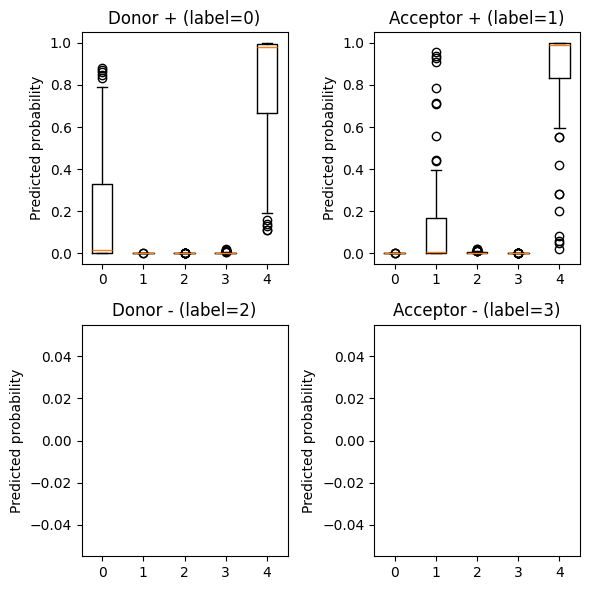

In [14]:
import matplotlib.pyplot as plt

# Plot boxplot of predicted probabilities for each class at true classes
plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.title("Donor + (label=0)")
plt.boxplot([splice_df[splice_df['label'] == 0][f'pred_{i}'] for i in range(5)], tick_labels=[f'{i}' for i in range(5)])
plt.ylabel("Predicted probability")
plt.subplot(2, 2, 2)
plt.title("Acceptor + (label=1)")
plt.boxplot([splice_df[splice_df['label'] == 1][f'pred_{i}'] for i in range(5)], tick_labels=[f'{i}' for i in range(5)])
plt.ylabel("Predicted probability")
plt.subplot(2, 2, 3)
plt.title("Donor - (label=2)")
plt.boxplot([splice_df[splice_df['label'] == 2][f'pred_{i}'] for i in range(5)], tick_labels=[f'{i}' for i in range(5)])
plt.ylabel("Predicted probability")
plt.subplot(2, 2, 4)
plt.title("Acceptor - (label=3)")
plt.boxplot([splice_df[splice_df['label'] == 3][f'pred_{i}'] for i in range(5)], tick_labels=[f'{i}' for i in range(5)])
plt.ylabel("Predicted probability")
plt.tight_layout()
plt.show()

No samples for human in this batch.


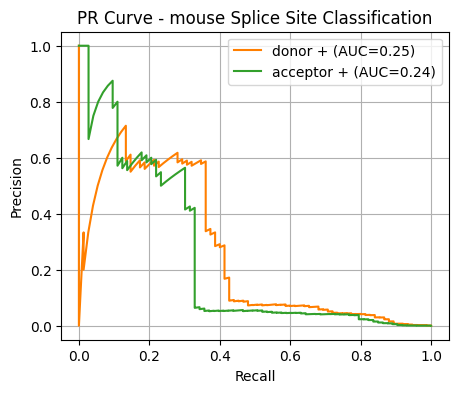

In [16]:
pr_auc_scores = {}
class_labels = {0: 'donor +', 1: 'acceptor +', 2: 'donor -', 3: 'acceptor -', 4: 'no splice site'}
class_colors = {0: '#ff7f00', 1: '#33a02c', 2:'#fdbf6f', 3: '#b2df8a', 4: '#1f78b4'}

for org in splice_logits.keys():

    if splice_logits[org].shape[0] == 0:
        print(f"No samples for {org} in this batch.")
        continue

    splice_logits_flat = splice_logits[org].reshape(-1, splice_logits[org].shape[-1]).detach().to('cpu').numpy()
    splice_labels_flat = splice_labels_true[org].reshape(-1).detach().to('cpu').numpy()

    from sklearn.metrics import precision_recall_curve, auc

    plt.figure(figsize=(5, 4))

    for i in range(4):
        color = class_colors[i]
        label = class_labels[i]
        
        class_idx = splice_labels_flat == i
        y_true = np.zeros_like(splice_labels_flat)
        y_true[class_idx] = 1
        y_scores = splice_logits_flat[:, i]

        if len(y_true) > 0 and y_true.sum() > 0:
            precision, recall, _ = precision_recall_curve(y_true, y_scores)
            pr_auc = auc(recall, precision)
            pr_auc_scores[i] = pr_auc
            
            plt.plot(recall, precision, label=f"{label} (AUC={pr_auc:.2f})", color=color)
        else:
            pr_auc_scores[i] = 0.0
            print(f"  Warning: No positive samples for {label}") 

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR Curve - {org} Splice Site Classification")
    plt.legend()
    plt.grid()
    plt.show()

### Splice usage predictions

In [24]:
# Only evaluate splice site positions (labels != 0)
splice_site_mask = splice_labels != 4  # (batch, seq_len)
donor_plus_mask = splice_labels == 0
acceptor_plus_mask = splice_labels == 1
donor_minus_mask = splice_labels == 2
acceptor_minus_mask = splice_labels == 3

if splice_site_mask.any():

    usage_true_bins_ = {}
    usage_pred_ = {}
    usage_true_ = {}

    for org in predictions:
        
        if splice_logits[org].shape[0] == 0:
            print(f"No samples for {org} in this batch.")
            continue

        print(f"\nEvaluating splice usage predictions for {org} at splice site positions:")

        # Predicted and true splice usage
        org_sse_pred = predictions[org]['splice_sites_usage'].sigmoid()
        org_sse_true = splice_usage

        # Select only splice site positions
        usage_true_at_sites = org_sse_true[splice_site_mask, :]
        usage_pred_at_sites = org_sse_pred[splice_site_mask, :]

        # Subset by organism
        usage_true_at_sites = usage_true_at_sites[:,species_conds[org]]
        usage_pred_at_sites = usage_pred_at_sites[:,range(len(species_conds[org]))]

        # Convert to numpy for evaluation
        usage_true_org = usage_true_at_sites.detach().cpu().numpy()
        usage_pred_org = usage_pred_at_sites.detach().cpu().numpy()

        # Remove rows with all zeros in true usage (not used for evaluation)
        non_zero_rows = ~np.all(usage_true_org == 0, axis=1)
        usage_true_org = usage_true_org[non_zero_rows]
        usage_pred_org = usage_pred_org[non_zero_rows]

        # Flatten for plotting
        cols = species_conds[org]  # Get columns corresponding to the condition of the organism
        usage_pred_[org] = usage_pred_org.flatten()
        usage_true_[org] = usage_true_org.flatten()

        # Group true usage in bins: 0 - 0.2 - 0.5 - 0.8 - 1.0
        usage_true_bins = np.zeros_like(usage_true_[org], dtype=int)
        usage_true_bins[usage_true_[org] < 0.2] = 0
        usage_true_bins[(usage_true_[org] >= 0.2) & (usage_true_[org] < 0.5)] = 1
        usage_true_bins[(usage_true_[org] >= 0.5) & (usage_true_[org] < 0.8)] = 2
        usage_true_bins[usage_true_[org] >= 0.8] = 3

        usage_true_bins_[org] = usage_true_bins

        # Count number of values in each bin
        for i in range(4):
            count = np.sum(usage_true_bins == i)
            print(f"True usage bin {i}: {count} values")



Evaluating splice usage predictions for human at splice site positions:
True usage bin 0: 706 values
True usage bin 1: 30 values
True usage bin 2: 96 values
True usage bin 3: 688 values

Evaluating splice usage predictions for mouse at splice site positions:
True usage bin 0: 1200 values
True usage bin 1: 71 values
True usage bin 2: 254 values
True usage bin 3: 1637 values


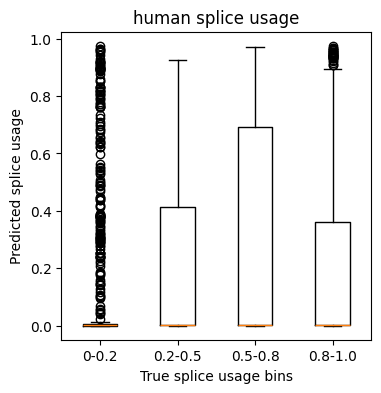

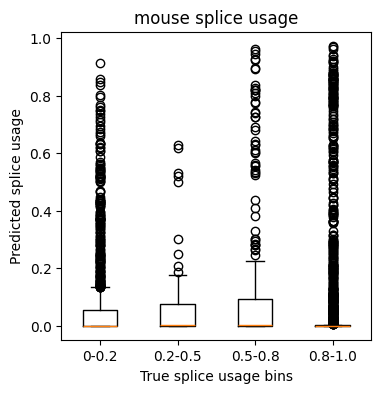

In [25]:
# Plot boxplot of predicted usage for each true usage bin
for org in usage_pred_.keys():

    if splice_logits[org].shape[0] == 0:
        print(f"No samples for {org} in this batch.")
        continue

    plt.figure(figsize=(4, 4))
    plt.title(f"{org} splice usage")
    plt.boxplot([usage_pred_[org][usage_true_bins_[org] == i] for i in range(4)], tick_labels=['0-0.2', '0.2-0.5', '0.5-0.8', '0.8-1.0'])
    plt.ylabel("Predicted splice usage")
    plt.xlabel("True splice usage bins")
    #plt.ylim(0, 1)
    plt.show()

Correlation between true and predicted splice usage for human: 0.533


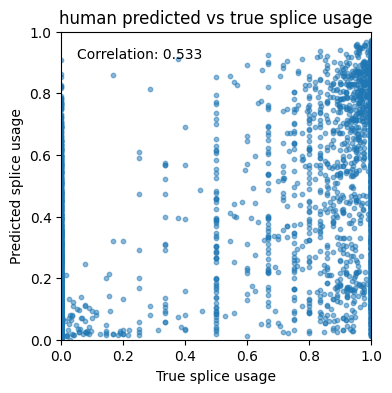

In [20]:
for org in usage_pred_.keys():

    if splice_logits[org].shape[0] == 0:
        print(f"No samples for {org} in this batch.")
        continue

    # Calculate correlation between true and predicted usage at splice sites
    correlation = np.corrcoef(usage_true_[org], usage_pred_[org])[0, 1]
    print(f"Correlation between true and predicted splice usage for {org}: {correlation:.3f}")

    # Plot scatter plot of predicted usage vs true usage
    plt.figure(figsize=(4, 4))
    plt.title(f"{org} predicted vs true splice usage")
    plt.scatter(usage_true_[org], usage_pred_[org], alpha=0.5, s=10)
    plt.xlabel("True splice usage")
    plt.ylabel("Predicted splice usage")
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    # Add correlation text
    plt.text(0.05, 0.95, f"Correlation: {correlation:.3f}", transform=plt.gca().transAxes, verticalalignment='top')

    plt.show()

In [ ]:
# Combine in a DataFrame: org, condition_idx, true_usage, pred_usage
data_arrays = {
    'organism': [],
    'sequence_idx': [],
    'position': [],
    'true_usage': [],
    'pred_usage': [],
    'condition_idx': [],
    'condition_name': [],
    'tissue': [],
    'timepoint': []
}

for org in predictions:
    print(f"\nBuilding dataframe for {org}:")
    
    # Get organism-specific mask
    org_mask = organism_index == species_mapping[org]
    
    # Get organism-specific predictions and true values
    org_sse_pred = predictions[org]['splice_sites_usage'].sigmoid()
    org_sse_pred = org_sse_pred[org_mask]
    org_sse_true = splice_usage[org_mask]
    
    # Get splice site positions for this organism
    org_splice_mask = splice_site_mask[org_mask]
    
    # Get sequence and position indices for splice sites
    splice_site_indices = torch.where(org_splice_mask)
    sequence_indices = splice_site_indices[0].cpu().numpy()  # Which sequence (dim 0)
    position_indices = splice_site_indices[1].cpu().numpy()  # Which position (dim 1)
    
    # Select only splice site positions
    usage_true_at_sites = org_sse_true[org_splice_mask, :]
    usage_pred_at_sites = org_sse_pred[org_splice_mask, :]
    
    # Get condition indices for this organism
    org_conds = species_conds[org]
    num_sites = usage_true_at_sites.shape[0]
    num_conds = len(org_conds)
    
    # Convert to numpy once
    true_vals = usage_true_at_sites.cpu().numpy()  # shape: (num_sites, num_total_conditions)
    pred_vals = usage_pred_at_sites.detach().cpu().numpy()  # shape: (num_sites, num_org_conditions)
    
    # Build arrays for this organism
    for cond_idx_pred, cond_idx_true in enumerate(org_conds):
        cond_name = metadata['usage_conditions'][cond_idx_true]
        tissue, timepoint = cond_name.split('_')
        data_arrays['organism'].append(np.full(num_sites, org, dtype=object))
        data_arrays['true_usage'].append(true_vals[:, cond_idx_true])
        data_arrays['pred_usage'].append(pred_vals[:, cond_idx_pred])
        data_arrays['sequence_idx'].append(sequence_indices)
        data_arrays['position'].append(position_indices)
        data_arrays['condition_idx'].append(np.full(num_sites, cond_idx_true, dtype=int))
        data_arrays['condition_name'].append(np.full(num_sites, cond_name, dtype=object))
        data_arrays['tissue'].append(np.full(num_sites, tissue, dtype=object))
        data_arrays['timepoint'].append(np.full(num_sites, timepoint, dtype=object))
    
    print(f"  Added {num_sites * num_conds} rows for {org}")

# Concatenate all arrays at once
all_data_df = pd.DataFrame({
    'organism': np.concatenate(data_arrays['organism']),
    'sequence_idx': np.concatenate(data_arrays['sequence_idx']),
    'position': np.concatenate(data_arrays['position']),
    'true_usage': np.concatenate(data_arrays['true_usage']),
    'pred_usage': np.concatenate(data_arrays['pred_usage']),
    'condition_idx': np.concatenate(data_arrays['condition_idx']),
    'condition_name': np.concatenate(data_arrays['condition_name']),
    'tissue': np.concatenate(data_arrays['tissue']),
    'timepoint': np.concatenate(data_arrays['timepoint'])
})

print(f"\nTotal rows in dataframe: {len(all_data_df)}")

# How many conditions/tissues/timepoints have true_usage > 0 for each site?
site_stats = all_data_df[all_data_df['true_usage'] > 0].groupby(['sequence_idx', 'position']).agg({
    'condition_idx': 'nunique',
    'timepoint': 'nunique',
    'tissue': 'nunique'
}).rename(columns={
    'condition_idx': 'num_conditions',
    'timepoint': 'num_timepoints',
    'tissue': 'num_tissues'
})

# Merge back to the original dataframe
all_data_df = all_data_df.merge(site_stats, on=['sequence_idx', 'position'], how='left').fillna(0)
all_data_df['num_conditions'] = all_data_df['num_conditions'].astype(int)
all_data_df['num_timepoints'] = all_data_df['num_timepoints'].astype(int)
all_data_df['num_tissues'] = all_data_df['num_tissues'].astype(int)

# Only evaluate position with usage data
all_data_df = all_data_df[all_data_df['num_conditions'] > 0]

print(f"\nTotal rows in dataframe: {len(all_data_df)}")

all_data_df


Building dataframe for human:
  Added 8240 rows for human

Building dataframe for mouse:
  Added 0 rows for mouse

Total rows in dataframe: 8240

Total rows in dataframe: 4064


,organism,sequence_idx,position,true_usage,pred_usage,condition_idx,condition_name,tissue,timepoint,num_conditions,num_timepoints,num_tissues
0,human,0,615,0.000,0.543816,0,Brain_10,Brain,10,15,5,7
2,human,0,2566,0.000,0.057246,0,Brain_10,Brain,10,5,3,5
3,human,0,2624,1.000,0.401651,0,Brain_10,Brain,10,16,5,7
5,human,0,3460,1.000,0.535567,0,Brain_10,Brain,10,15,5,7
7,human,0,9553,0.000,0.406974,0,Brain_10,Brain,10,15,5,7
...,...,...,...,...,...,...,...,...,...,...,...,...
8228,human,125,2324,0.000,0.122726,37,Testis_15,Testis,15,3,3,1
8229,human,125,2366,0.000,0.254984,37,Testis_15,Testis,15,5,5,1
8234,human,127,9150,0.667,0.572800,37,Testis_15,Testis,15,16,5,7
8236,human,127,9534,1.000,0.651231,37,Testis_15,Testis,15,16,5,7


Per-condition splice usage predictions and true values.

In [22]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_sse_density(
        all_data_df: pd.DataFrame, 
        group_by: str, 
        output_dir: Path = None,
        log_fn=print
    ):
        """Plot density of predicted vs true SSE values.
        Args:
            all_data_df: DataFrame with SSE data, it should contain columns 'true_usage' and 'pred_usage' along with grouping columns
            group_by: Column name or list of column names to group by
            output_dir: Directory to save output
            log_fn: Logging function
        """
            
        log_fn("Plotting SSE density...")
        
        # Get valid positions where we have both true and predicted SSE
        valid_data = all_data_df.dropna(subset=['true_usage', 'pred_usage'])

        # Get unique combinations of grouping variables
        groups = valid_data.groupby(group_by).size().reset_index(name='count')
        num_groups = len(groups)
        
        # Determine subplot layout
        num_cols = min(3, num_groups)  # Max 3 columns
        num_rows = (num_groups + num_cols - 1) // num_cols
        
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4.8, num_rows * 4), squeeze=False)
        
        for i, (group_idx, group_row) in enumerate(groups.iterrows()):
            # Build filter for this group
            mask = pd.Series([True] * len(valid_data), index=valid_data.index)
            for col in group_by:
                mask &= (valid_data[col] == group_row[col])
            
            condition_data = valid_data[mask]
            
            # Build title from group values
            if len(group_by) == 1:
                title = f"{group_row[group_by[0]]}"
            else:
                title = ", ".join([f"{col}: {group_row[col]}" for col in group_by])
            
            row = i // num_cols
            col = i % num_cols
            ax = axs[row, col]
                    
            # 2D hexbin plot
            hb = ax.hexbin(
                condition_data['true_usage'],
                condition_data['pred_usage'],
                gridsize=30,
                cmap='rocket_r',
                mincnt=1
            )
            plt.colorbar(
                hb,
                ax=ax,
                label='Count',
                pad=0.2
            )
            
            # Add pearson correlation value and number of points to plot
            num_points = len(condition_data)
            if num_points >= 2:
                corr = np.corrcoef(condition_data['true_usage'], condition_data['pred_usage'])[0, 1]
                ax.text(0.05, 0.95, f"r = {corr:.2f}\nn = {num_points}", transform=ax.transAxes, fontsize=10, verticalalignment='top')    
            else:
                ax.text(0.05, 0.95, f"n = {num_points}", transform=ax.transAxes, fontsize=10, verticalalignment='top')
                
            # Top histogram (True SSE)
            ax_histx = ax.inset_axes([0, 1.05, 1, 0.2], sharex=ax)
            ax_histx.hist(condition_data['true_usage'], bins=30, color='gray', alpha=0.7)
            ax_histx.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
            
            # Right histogram (Pred SSE)
            ax_histy = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)
            ax_histy.hist(condition_data['pred_usage'], bins=30, orientation='horizontal', color='gray', alpha=0.7)
            ax_histy.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)
            
            ax.set_xlabel('True Usage', fontsize=10)
            ax.set_ylabel('Predicted Usage', fontsize=10)
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_title(title, fontsize=12)
            ax.grid()
        
        # Hide unused subplots
        for i in range(num_groups, num_rows * num_cols):
            row = i // num_cols
            col = i % num_cols
            axs[row, col].set_visible(False)
        
        plt.tight_layout()
        if output_dir is not None:
            density_plot = output_dir / "sse_density.png"
            plt.savefig(density_plot, dpi=150)
            plt.close()
            log_fn(f"Saved density plot to {density_plot}")
        else:
            plt.show()

Plotting SSE density...


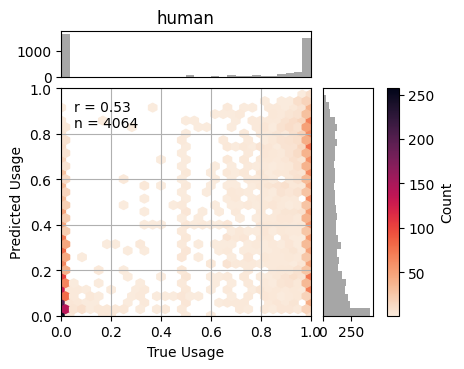

In [24]:
%matplotlib inline
plot_sse_density(
    all_data_df,
    group_by=['organism']
)

## Load all predictions

### Parse predictions data

Load genomic coord info for samples in the batches of test data

In [ ]:
model_dir = "/home/elek/sds/sd17d003/Anamaria/alphagenome_pytorch/adult_mouse_human_50kb"
preds_dir = os.path.join(model_dir, "predictions")
batch_map_fn = os.path.join(preds_dir, "batch_sample_mapping.csv")
batch_map_df = pd.read_csv(batch_map_fn)
batch_map_df

,batch_idx,sample_idx,chromosome,gene_id,genome_id,n_acceptor_sites,n_donor_sites,strand,window_end,window_start,species_id
0,0,0,11,hum.10118,human_GRCh37,0,1,+,26403869,26353869,0
1,0,1,11,hum.10118,human_GRCh37,3,4,+,26503869,26453869,0
2,0,2,11,hum.10118,human_GRCh37,8,8,+,26553869,26503869,0
3,0,3,11,hum.10118,human_GRCh37,12,12,+,26603869,26553869,0
4,0,4,11,hum.10118,human_GRCh37,8,8,+,26653869,26603869,0
...,...,...,...,...,...,...,...,...,...,...,...
2325,291,2325,4,mou.33629,mouse_GRCm38,11,8,-,156293603,156243603,1
2326,291,2326,4,mou.33613,mouse_GRCm38,0,7,+,156101319,156051319,1
2327,291,2327,4,mou.33613,mouse_GRCm38,390,388,+,156151319,156101319,1
2328,291,2328,4,mou.33591,mouse_GRCm38,701,704,+,155853096,155803096,1


Load splice classification predictions

In [ ]:
preds_splice_fn = os.path.join(preds_dir, "splice_site_predictions_all.csv.gz")
preds_splice_df = pd.read_csv(preds_splice_fn)
preds_splice_df

,organism,dataset_sample_idx,batch_sample_idx,position,label,pred_0,pred_1,pred_2,pred_3,pred_4
0,human,1,1,9171,1,0.000134,0.828405,0.003205,0.000033,0.168223
1,human,1,1,9365,0,0.539149,0.000724,0.000173,0.001638,0.458315
2,human,1,1,11018,1,0.000987,0.630304,0.001286,0.000143,0.367280
3,human,1,1,11089,0,0.919393,0.000219,0.000026,0.001228,0.079133
4,human,1,1,30283,1,0.007758,0.447533,0.000785,0.001061,0.542863
...,...,...,...,...,...,...,...,...,...,...
23342,mouse,2329,4,10925,0,0.000116,0.000008,0.000004,0.000022,0.999850
23343,mouse,2329,4,10937,0,0.000113,0.000021,0.000012,0.000035,0.999819
23344,mouse,2329,4,10941,0,0.000145,0.000030,0.000015,0.000046,0.999764
23345,mouse,2329,4,16506,1,0.000020,0.000007,0.000009,0.000019,0.999945


Add predicted class labels based on predicted probabilities

In [21]:
preds_splice_df['pred_label'] = preds_splice_df[[f'pred_{i}' for i in range(5)]].idxmax(axis=1).str.replace('pred_', '').astype(int)
preds_splice_df

,organism,dataset_sample_idx,batch_sample_idx,position,label,pred_0,pred_1,pred_2,pred_3,pred_4,pred_label
0,human,1,1,9171,1,0.000134,0.828405,0.003205,0.000033,0.168223,1
1,human,1,1,9365,0,0.539149,0.000724,0.000173,0.001638,0.458315,0
2,human,1,1,11018,1,0.000987,0.630304,0.001286,0.000143,0.367280,1
3,human,1,1,11089,0,0.919393,0.000219,0.000026,0.001228,0.079133,0
4,human,1,1,30283,1,0.007758,0.447533,0.000785,0.001061,0.542863,4
...,...,...,...,...,...,...,...,...,...,...,...
23342,mouse,2329,4,10925,0,0.000116,0.000008,0.000004,0.000022,0.999850,4
23343,mouse,2329,4,10937,0,0.000113,0.000021,0.000012,0.000035,0.999819,4
23344,mouse,2329,4,10941,0,0.000145,0.000030,0.000015,0.000046,0.999764,4
23345,mouse,2329,4,16506,1,0.000020,0.000007,0.000009,0.000019,0.999945,4


Load splice usage predictions

In [ ]:
preds_usage_fn = os.path.join(preds_dir, "splice_usage_predictions_all.csv.gz")
preds_usage_df = pd.read_csv(preds_usage_fn)
preds_usage_df

,organism,dataset_sample_idx,batch_sample_idx,position,true_usage,pred_usage,condition_idx,condition_name,tissue,timepoint,num_conditions,num_timepoints,num_tissues
0,human,1.0,1,9171,0.000,0.485285,0,Brain_10,Brain,10,7,5,5
1,human,1.0,1,11018,1.000,0.570231,0,Brain_10,Brain,10,6,4,3
2,human,1.0,1,30283,0.000,0.453023,0,Brain_10,Brain,10,3,3,2
3,human,2.0,2,25357,1.000,0.670436,0,Brain_10,Brain,10,6,3,3
4,human,3.0,3,1709,1.000,0.412061,0,Brain_10,Brain,10,5,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
340455,mouse,2329.0,4,8671,0.867,0.748992,36,Testis_14,Testis,14,34,5,7
340456,mouse,2329.0,4,8934,0.909,0.753969,36,Testis_14,Testis,14,31,5,7
340457,mouse,2329.0,4,9335,0.833,0.695695,36,Testis_14,Testis,14,29,5,7
340458,mouse,2329.0,4,10181,0.920,0.722793,36,Testis_14,Testis,14,28,5,7


In [23]:
# dataset_sample_idx should be integer and renamed to sample_idx in both dataframes for merging
preds_splice_df['dataset_sample_idx'] = preds_splice_df['dataset_sample_idx'].astype(int)
preds_usage_df['dataset_sample_idx'] = preds_usage_df['dataset_sample_idx'].astype(int)
preds_splice_df.rename(columns={'dataset_sample_idx': 'sample_idx'}, inplace=True)
preds_usage_df.rename(columns={'dataset_sample_idx': 'sample_idx'}, inplace=True)

In [24]:
# site column should be sample_idx_position
preds_splice_df['site'] = preds_splice_df['sample_idx'].astype(str) + "_" + preds_splice_df['position'].astype(str)
preds_usage_df['site'] = preds_usage_df['sample_idx'].astype(str) + "_" + preds_usage_df['position'].astype(str)

Combine predictions in a DataFrame for plotting.

In [25]:
# Ensure all key columns match types
key_cols = ["organism", "sample_idx", "batch_sample_idx", "position", "site"]
for col in key_cols:
    preds_usage_df[col] = preds_usage_df[col].astype(preds_splice_df[col].dtype)

# Merge
merged_df = preds_usage_df.merge(
    preds_splice_df[["organism", "sample_idx", "batch_sample_idx", "position", "site", "label", "pred_label"]],
    on=key_cols,
    how="left",
    copy=False,
    sort=False
)

Calculate pre-site correlation between predicted and true usage values across timepoints and tissues.

In [26]:
key_cols = ["organism", "sample_idx", "batch_sample_idx", "position", "site"]

def corr_func(x):
    return x["true_usage"].corr(x["pred_usage"])

site_corr = (
    merged_df
    .groupby(key_cols, sort=False)[["true_usage", "pred_usage"]]
    .corr()
    .unstack()
    .iloc[:, 1]
    .reset_index(name="site_correlation")
)

merged_df = merged_df.merge(site_corr, on=key_cols, how="left")


Add genomic coordinates to the predictions.

In [27]:
merged_ann_df = merged_df.merge(
    batch_map_df,
    on="sample_idx",
    how="left",
    copy=False,
    sort=False
)
merged_ann_df

,organism,sample_idx,batch_sample_idx,position,true_usage,pred_usage,condition_idx,condition_name,tissue,timepoint,...,batch_idx,chromosome,gene_id,genome_id,n_acceptor_sites,n_donor_sites,strand,window_end,window_start,species_id
0,human,1,1,9171,0.000,0.485285,0,Brain_10,Brain,10,...,0,11,hum.10118,human_GRCh37,3,4,+,26503869,26453869,0
1,human,1,1,11018,1.000,0.570231,0,Brain_10,Brain,10,...,0,11,hum.10118,human_GRCh37,3,4,+,26503869,26453869,0
2,human,1,1,30283,0.000,0.453023,0,Brain_10,Brain,10,...,0,11,hum.10118,human_GRCh37,3,4,+,26503869,26453869,0
3,human,2,2,25357,1.000,0.670436,0,Brain_10,Brain,10,...,0,11,hum.10118,human_GRCh37,8,8,+,26553869,26503869,0
4,human,3,3,1709,1.000,0.412061,0,Brain_10,Brain,10,...,0,11,hum.10118,human_GRCh37,12,12,+,26603869,26553869,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340455,mouse,2329,4,8671,0.867,0.748992,36,Testis_14,Testis,14,...,291,4,mou.33628,mouse_GRCm38,473,475,+,156286071,156236071,1
340456,mouse,2329,4,8934,0.909,0.753969,36,Testis_14,Testis,14,...,291,4,mou.33628,mouse_GRCm38,473,475,+,156286071,156236071,1
340457,mouse,2329,4,9335,0.833,0.695695,36,Testis_14,Testis,14,...,291,4,mou.33628,mouse_GRCm38,473,475,+,156286071,156236071,1
340458,mouse,2329,4,10181,0.920,0.722793,36,Testis_14,Testis,14,...,291,4,mou.33628,mouse_GRCm38,473,475,+,156286071,156236071,1


In [28]:
# Order columns
final_df = merged_ann_df[[
    "organism", "species_id", "sample_idx", "batch_idx", "batch_sample_idx", "genome_id", "gene_id", 
    "chromosome", "window_start", "window_end", "position", "strand", "site", 
    "label", "pred_label", "true_usage", "pred_usage",
    "condition_idx", "condition_name", "tissue", "timepoint", 
    "num_conditions", "num_timepoints", "num_tissues", "site_correlation"
]]
final_df

,organism,species_id,sample_idx,batch_idx,batch_sample_idx,genome_id,gene_id,chromosome,window_start,window_end,...,true_usage,pred_usage,condition_idx,condition_name,tissue,timepoint,num_conditions,num_timepoints,num_tissues,site_correlation
0,human,0,1,0,1,human_GRCh37,hum.10118,11,26453869,26503869,...,0.000,0.485285,0,Brain_10,Brain,10,7,5,5,0.733161
1,human,0,1,0,1,human_GRCh37,hum.10118,11,26453869,26503869,...,1.000,0.570231,0,Brain_10,Brain,10,6,4,3,0.759745
2,human,0,1,0,1,human_GRCh37,hum.10118,11,26453869,26503869,...,0.000,0.453023,0,Brain_10,Brain,10,3,3,2,0.434568
3,human,0,2,0,2,human_GRCh37,hum.10118,11,26503869,26553869,...,1.000,0.670436,0,Brain_10,Brain,10,6,3,3,0.842234
4,human,0,3,0,3,human_GRCh37,hum.10118,11,26553869,26603869,...,1.000,0.412061,0,Brain_10,Brain,10,5,3,3,0.738579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340455,mouse,1,2329,291,4,mouse_GRCm38,mou.33628,4,156236071,156286071,...,0.867,0.748992,36,Testis_14,Testis,14,34,5,7,-0.402486
340456,mouse,1,2329,291,4,mouse_GRCm38,mou.33628,4,156236071,156286071,...,0.909,0.753969,36,Testis_14,Testis,14,31,5,7,-0.055640
340457,mouse,1,2329,291,4,mouse_GRCm38,mou.33628,4,156236071,156286071,...,0.833,0.695695,36,Testis_14,Testis,14,29,5,7,0.034406
340458,mouse,1,2329,291,4,mouse_GRCm38,mou.33628,4,156236071,156286071,...,0.920,0.722793,36,Testis_14,Testis,14,28,5,7,0.016438


In [ ]:
final_df.to_csv(os.path.join(preds_dir, "merged_predictions.csv.gz"), index=False, compression="gzip")

In [30]:
final_df

,organism,species_id,sample_idx,batch_idx,batch_sample_idx,genome_id,gene_id,chromosome,window_start,window_end,...,true_usage,pred_usage,condition_idx,condition_name,tissue,timepoint,num_conditions,num_timepoints,num_tissues,site_correlation
0,human,0,1,0,1,human_GRCh37,hum.10118,11,26453869,26503869,...,0.000,0.485285,0,Brain_10,Brain,10,7,5,5,0.733161
1,human,0,1,0,1,human_GRCh37,hum.10118,11,26453869,26503869,...,1.000,0.570231,0,Brain_10,Brain,10,6,4,3,0.759745
2,human,0,1,0,1,human_GRCh37,hum.10118,11,26453869,26503869,...,0.000,0.453023,0,Brain_10,Brain,10,3,3,2,0.434568
3,human,0,2,0,2,human_GRCh37,hum.10118,11,26503869,26553869,...,1.000,0.670436,0,Brain_10,Brain,10,6,3,3,0.842234
4,human,0,3,0,3,human_GRCh37,hum.10118,11,26553869,26603869,...,1.000,0.412061,0,Brain_10,Brain,10,5,3,3,0.738579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340455,mouse,1,2329,291,4,mouse_GRCm38,mou.33628,4,156236071,156286071,...,0.867,0.748992,36,Testis_14,Testis,14,34,5,7,-0.402486
340456,mouse,1,2329,291,4,mouse_GRCm38,mou.33628,4,156236071,156286071,...,0.909,0.753969,36,Testis_14,Testis,14,31,5,7,-0.055640
340457,mouse,1,2329,291,4,mouse_GRCm38,mou.33628,4,156236071,156286071,...,0.833,0.695695,36,Testis_14,Testis,14,29,5,7,0.034406
340458,mouse,1,2329,291,4,mouse_GRCm38,mou.33628,4,156236071,156286071,...,0.920,0.722793,36,Testis_14,Testis,14,28,5,7,0.016438


***

In [47]:
genome_dir = "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf"

human_bed_fn = "/home/elek/sds/sd17d003/Anamaria/borzoi_folds/Homo_sapiens.transcripts.bed"
human_bed = pd.read_csv(human_bed_fn, sep="\t", header=None, names=["chrom", "start", "end", "gene_id", "transcript_id", "strand"])
print(human_bed.head())

mouse_bed_fn = "/home/elek/sds/sd17d003/Anamaria/borzoi_folds/Mus_musculus.transcripts.bed"
mouse_bed = pd.read_csv(mouse_bed_fn, sep="\t", header=None, names=["chrom", "start", "end", "gene_id", "transcript_id", "strand"])
print(mouse_bed.head())

/tmp/ipykernel_1830116/854967682.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  human_bed = pd.read_csv(human_bed_fn, sep="\t", header=None, names=["chrom", "start", "end", "gene_id", "transcript_id", "strand"])


  chrom  start    end gene_id transcript_id strand
0     1  11609  14412   hum.1       hum.1.1      +
1     1  14332  29442   hum.2       hum.2.1      -
2     1  14332  29436   hum.2       hum.2.2      -
3     1  14335  29442   hum.2       hum.2.3      -
4     1  14335  30082   hum.2       hum.2.4      -
  chrom    start      end gene_id transcript_id strand
0     1  3057716  3057999   mou.1       mou.1.1      +
1     1  3151275  3151544   mou.2       mou.2.1      +
2     1  3152096  3154131   mou.3       mou.3.1      +
3     1  3986251  3986486   mou.4       mou.4.1      -
4     1  3873266  3908576   mou.5       mou.5.1      +


/tmp/ipykernel_1830116/854967682.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  mouse_bed = pd.read_csv(mouse_bed_fn, sep="\t", header=None, names=["chrom", "start", "end", "gene_id", "transcript_id", "strand"])


In [ ]:
# Get gene coords from min start and max end of transcripts
human_bed['gene_start'] = human_bed.groupby('gene_id')['start'].transform('min')
human_bed['gene_end'] = human_bed.groupby('gene_id')['end'].transform('max')
human_genes_bed = human_bed[['chrom', 'gene_start', 'gene_end', 'gene_id', 'strand']].drop_duplicates()
human_genes_bed['gene_length'] = human_genes_bed['gene_end'] - human_genes_bed['gene_start']
print(human_genes_bed.head())

mouse_bed['gene_start'] = mouse_bed.groupby('gene_id')['start'].transform('min')
mouse_bed['gene_end'] = mouse_bed.groupby('gene_id')['end'].transform('max')
mouse_genes_bed = mouse_bed[['chrom', 'gene_start', 'gene_end', 'gene_id', 'strand']].drop_duplicates()
mouse_genes_bed['gene_length'] = mouse_genes_bed['gene_end'] - mouse_genes_bed['gene_start']
print(mouse_genes_bed.head())

genes_bed = pd.concat([human_genes_bed, mouse_genes_bed], ignore_index=True)


In [52]:
preds_splice_ann = preds_splice_df.merge(
    batch_map_df,
    on="sample_idx",
    how="left",
    copy=False,
    sort=False
)
preds_splice_ann

,organism,sample_idx,batch_sample_idx,position,label,pred_0,pred_1,pred_2,pred_3,pred_4,...,batch_idx,chromosome,gene_id,genome_id,n_acceptor_sites,n_donor_sites,strand,window_end,window_start,species_id
0,human,1,1,9171,1,0.000134,0.828405,0.003205,0.000033,0.168223,...,0,11,hum.10118,human_GRCh37,3,4,+,26503869,26453869,0
1,human,1,1,9365,0,0.539149,0.000724,0.000173,0.001638,0.458315,...,0,11,hum.10118,human_GRCh37,3,4,+,26503869,26453869,0
2,human,1,1,11018,1,0.000987,0.630304,0.001286,0.000143,0.367280,...,0,11,hum.10118,human_GRCh37,3,4,+,26503869,26453869,0
3,human,1,1,11089,0,0.919393,0.000219,0.000026,0.001228,0.079133,...,0,11,hum.10118,human_GRCh37,3,4,+,26503869,26453869,0
4,human,1,1,30283,1,0.007758,0.447533,0.000785,0.001061,0.542863,...,0,11,hum.10118,human_GRCh37,3,4,+,26503869,26453869,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23342,mouse,2329,4,10925,0,0.000116,0.000008,0.000004,0.000022,0.999850,...,291,4,mou.33628,mouse_GRCm38,473,475,+,156286071,156236071,1
23343,mouse,2329,4,10937,0,0.000113,0.000021,0.000012,0.000035,0.999819,...,291,4,mou.33628,mouse_GRCm38,473,475,+,156286071,156236071,1
23344,mouse,2329,4,10941,0,0.000145,0.000030,0.000015,0.000046,0.999764,...,291,4,mou.33628,mouse_GRCm38,473,475,+,156286071,156236071,1
23345,mouse,2329,4,16506,1,0.000020,0.000007,0.000009,0.000019,0.999945,...,291,4,mou.33628,mouse_GRCm38,473,475,+,156286071,156236071,1


In [53]:
# add gene length to final_df
final_splice_df = preds_splice_ann.merge(
    genes_bed[['gene_id', 'gene_length']],
    on='gene_id',
    how='left'
)
final_splice_df

,organism,sample_idx,batch_sample_idx,position,label,pred_0,pred_1,pred_2,pred_3,pred_4,...,chromosome,gene_id,genome_id,n_acceptor_sites,n_donor_sites,strand,window_end,window_start,species_id,gene_length
0,human,1,1,9171,1,0.000134,0.828405,0.003205,0.000033,0.168223,...,11,hum.10118,human_GRCh37,3,4,+,26503869,26453869,0,331213
1,human,1,1,9365,0,0.539149,0.000724,0.000173,0.001638,0.458315,...,11,hum.10118,human_GRCh37,3,4,+,26503869,26453869,0,331213
2,human,1,1,11018,1,0.000987,0.630304,0.001286,0.000143,0.367280,...,11,hum.10118,human_GRCh37,3,4,+,26503869,26453869,0,331213
3,human,1,1,11089,0,0.919393,0.000219,0.000026,0.001228,0.079133,...,11,hum.10118,human_GRCh37,3,4,+,26503869,26453869,0,331213
4,human,1,1,30283,1,0.007758,0.447533,0.000785,0.001061,0.542863,...,11,hum.10118,human_GRCh37,3,4,+,26503869,26453869,0,331213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23342,mouse,2329,4,10925,0,0.000116,0.000008,0.000004,0.000022,0.999850,...,4,mou.33628,mouse_GRCm38,473,475,+,156286071,156236071,1,88930
23343,mouse,2329,4,10937,0,0.000113,0.000021,0.000012,0.000035,0.999819,...,4,mou.33628,mouse_GRCm38,473,475,+,156286071,156236071,1,88930
23344,mouse,2329,4,10941,0,0.000145,0.000030,0.000015,0.000046,0.999764,...,4,mou.33628,mouse_GRCm38,473,475,+,156286071,156236071,1,88930
23345,mouse,2329,4,16506,1,0.000020,0.000007,0.000009,0.000019,0.999945,...,4,mou.33628,mouse_GRCm38,473,475,+,156286071,156236071,1,88930


In [55]:
# calculate accuracy of splice site classification for each gene
final_splice_df['splice_site_correct'] = final_splice_df['label'] == final_splice_df['pred_label']
gene_acc = final_splice_df.groupby('gene_id')['splice_site_correct'].mean().reset_index(name='splice_site_accuracy')
final_splice_df = final_splice_df.merge(
    gene_acc,
    on='gene_id',
    how='left'
)
final_splice_df

,organism,sample_idx,batch_sample_idx,position,label,pred_0,pred_1,pred_2,pred_3,pred_4,...,genome_id,n_acceptor_sites,n_donor_sites,strand,window_end,window_start,species_id,gene_length,splice_site_correct,splice_site_accuracy
0,human,1,1,9171,1,0.000134,0.828405,0.003205,0.000033,0.168223,...,human_GRCh37,3,4,+,26503869,26453869,0,331213,True,0.769231
1,human,1,1,9365,0,0.539149,0.000724,0.000173,0.001638,0.458315,...,human_GRCh37,3,4,+,26503869,26453869,0,331213,True,0.769231
2,human,1,1,11018,1,0.000987,0.630304,0.001286,0.000143,0.367280,...,human_GRCh37,3,4,+,26503869,26453869,0,331213,True,0.769231
3,human,1,1,11089,0,0.919393,0.000219,0.000026,0.001228,0.079133,...,human_GRCh37,3,4,+,26503869,26453869,0,331213,True,0.769231
4,human,1,1,30283,1,0.007758,0.447533,0.000785,0.001061,0.542863,...,human_GRCh37,3,4,+,26503869,26453869,0,331213,False,0.769231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23342,mouse,2329,4,10925,0,0.000116,0.000008,0.000004,0.000022,0.999850,...,mouse_GRCm38,473,475,+,156286071,156236071,1,88930,False,0.244444
23343,mouse,2329,4,10937,0,0.000113,0.000021,0.000012,0.000035,0.999819,...,mouse_GRCm38,473,475,+,156286071,156236071,1,88930,False,0.244444
23344,mouse,2329,4,10941,0,0.000145,0.000030,0.000015,0.000046,0.999764,...,mouse_GRCm38,473,475,+,156286071,156236071,1,88930,False,0.244444
23345,mouse,2329,4,16506,1,0.000020,0.000007,0.000009,0.000019,0.999945,...,mouse_GRCm38,473,475,+,156286071,156236071,1,88930,False,0.244444


In [75]:
genes_bed[genes_bed['gene_length'] < 50000]

,chrom,gene_start,gene_end,gene_id,strand,gene_length
0,1,11609,14412,hum.1,+,2803
1,1,14332,30082,hum.2,-,15750
2,1,1834378,1835146,hum.3,-,768
3,1,1837440,1837658,hum.4,-,218
4,1,1845278,1845643,hum.5,+,365
...,...,...,...,...,...,...
119920,Y,90766158,90774031,mou.50216,-,7873
119921,Y,90785407,90822477,mou.50217,-,37070
119922,Y,90818629,90824664,mou.50218,+,6035
119923,Y,90819086,90825225,mou.50219,+,6139


In [ ]:
preds_splice_ann[preds_splice_ann['gene_id'].isin(genes_bed[genes_bed['gene_length'] < 50000]['gene_id'])]

,organism,sample_idx,batch_sample_idx,position,label,pred_0,pred_1,pred_2,pred_3,pred_4,...,batch_idx,chromosome,gene_id,genome_id,n_acceptor_sites,n_donor_sites,strand,window_end,window_start,species_id


In [89]:
train_ann = pd.read_csv("/home/elek/sds/sd17d003/Anamaria/splicevo/data/processed_small_10kb/mouse_GRCm38/metadata.csv")
train_ann[train_ann['gene_id'].isin(genes_bed[genes_bed['gene_length'] < 10000]['gene_id'])]

,genome_id,chromosome,gene_id,strand,window_start,window_end,n_donor_sites,n_acceptor_sites
0,mouse_GRCm38,15,mou.15412,+,3252523,3262763,2,2
8,mouse_GRCm38,15,mou.15431,+,3328143,3338383,1,1
38,mouse_GRCm38,15,mou.15447,-,4069410,4079650,1,1
39,mouse_GRCm38,15,mou.15448,-,4091276,4101516,2,2
56,mouse_GRCm38,15,mou.15453,-,5116685,5126925,3,3
...,...,...,...,...,...,...,...,...
13302,mouse_GRCm38,19,mou.24132,+,60580902,60591142,1,1
13319,mouse_GRCm38,19,mou.24150,+,61176529,61186769,3,3
13325,mouse_GRCm38,19,mou.24154,-,61297515,61307755,3,3
13326,mouse_GRCm38,19,mou.24155,-,61303296,61313536,1,1


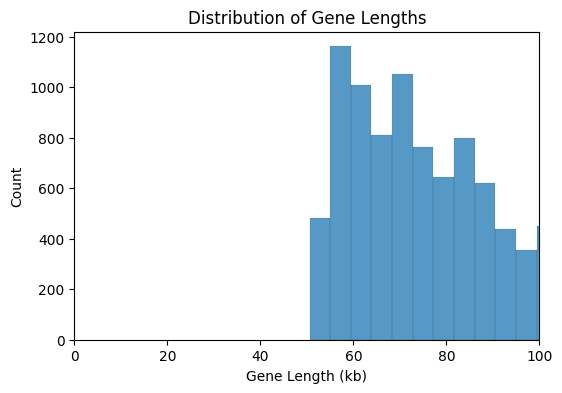

In [82]:
# plot distribution of gene lengths
plt.figure(figsize=(6, 4))
sns.histplot(final_splice_df['gene_length']/1000, bins=500)
plt.title("Distribution of Gene Lengths")
plt.xlabel("Gene Length (kb)")
plt.ylabel("Count")
plt.xlim(0, 100)
plt.show()

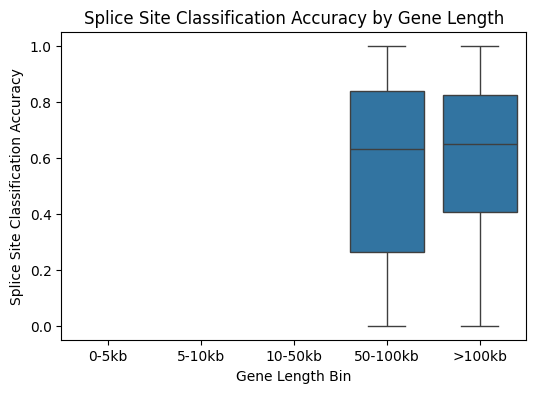

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

#plot accuracy boxplots per gene binned by gene length
final_splice_df['gene_length_bin'] = pd.cut(final_splice_df['gene_length'], bins=[0, 5e3, 10e3, 50e3, 100e3, np.inf], labels=['0-5kb', '5-10kb', '10-50kb', '50-100kb', '>100kb'])
plt.figure(figsize=(6, 4))
sns.boxplot(x='gene_length_bin', y='splice_site_accuracy', data=final_splice_df)
plt.xlabel('Gene Length Bin')
plt.ylabel('Splice Site Classification Accuracy')
plt.title('Splice Site Classification Accuracy by Gene Length')
plt.show()

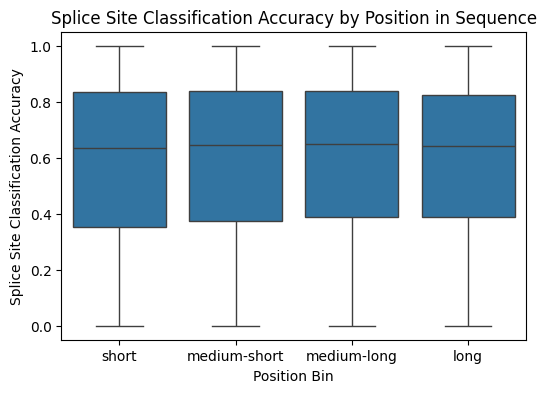

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

#plot accuracy boxplots per gene binned by position in the sequence
final_splice_df['gene_length_bin'] = pd.qcut(final_splice_df['position'], q=4, labels=['short', 'medium-short', 'medium-long', 'long'])
plt.figure(figsize=(6, 4))
sns.boxplot(x='gene_length_bin', y='splice_site_accuracy', data=final_splice_df)
plt.xlabel('Position Bin')
plt.ylabel('Splice Site Classification Accuracy')
plt.title('Splice Site Classification Accuracy by Position in Sequence')
plt.show()

### Correlations

In [ ]:
final_df = pd.read_csv(os.path.join(model_dir, "predictions", "merged_predictions.csv.gz"), compression="gzip")
final_df

Plot  histogram of site correlations per species (columns) and tissues (rows).

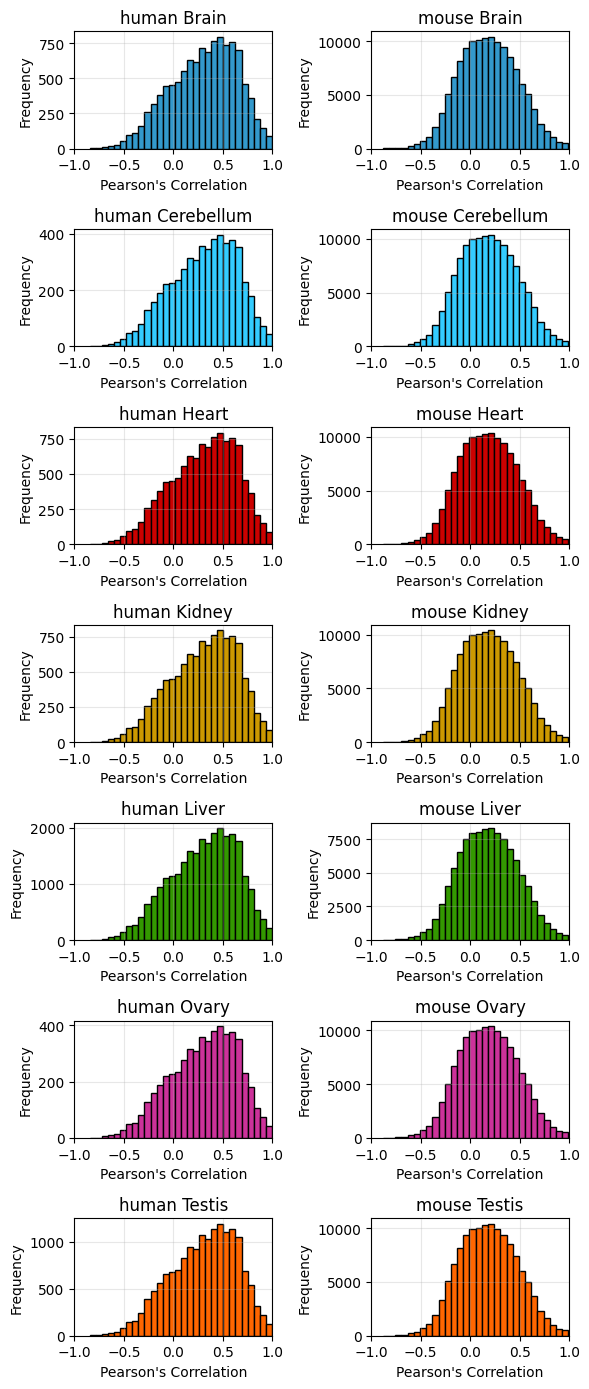

In [ ]:
# Define tissue colors
tissue_colors = {
    'Brain': '#3399cc',
    'Cerebellum': '#34ccff',
    'Heart': '#cc0100',
    'Kidney': '#cc9900',
    'Liver': '#339900',
    'Ovary': '#cc329a',
    'Testis': '#ff6600'
}

# Plot  histogram of site correlations per species (columns) and tissues (rows)
unique_tissues = final_df['tissue'].unique()
num_rows = len(unique_tissues)
unique_species = final_df['organism'].unique()
num_cols = len(unique_species)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 2), squeeze=False)
for col, species in enumerate(unique_species):
    for row, tissue in enumerate(unique_tissues):
        ax = axs[row, col]
        tissue_corrs = final_df[(final_df['tissue'] == tissue) & (final_df['organism'] == species)]['site_correlation'].dropna()
        tissue_color = tissue_colors.get(tissue, '#000000')
        ax.hist(tissue_corrs, bins=30, color=tissue_color, edgecolor='black')
        ax.set_title(f'{species} {tissue}', fontsize=12)
        ax.set_xlabel("Pearson's Correlation", fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        ax.set_xlim(-1, 1)
        ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Function to plot splice site usage across timepoints, per tissue

In [68]:
def plot_sse_timeseries(plot_df, tissue_colors, output_path=None, smooth=False, highlight_threshold=0.9, highlight_sites=None, title=None, show_legend=True):
    """
    Plot SSE timeseries for multiple splice sites and tissues.
    
    Args:
        plot_df: DataFrame with columns: site, tissue, timepoint, true_usage, pred_usage
        tissue_colors: Dictionary mapping tissue names to colors
        output_path: Path to save the figure (optional)
        smooth: Whether to apply spline smoothing to lines
        highlight_threshold: Correlation threshold for highlighting (default 0.9). Set to None to disable correlation-based highlighting.
        title: Optional title for the entire figure
        show_legend: Whether to show the legend (default True)
        highlight_sites: Dictionary mapping site names to list of tissues to highlight, e.g., {'site1': ['tissue1', 'tissue2']} or set to 'all' to highlight all tissues for that site
    
    Returns:
        matplotlib figure
    """
    unique_sites = plot_df['site'].unique()
    
    timepoint_order = sorted(plot_df['timepoint'].unique())
    plot_df['timepoint'] = pd.Categorical(plot_df['timepoint'], categories=timepoint_order, ordered=True)
    
    n_sites = len(unique_sites)
    unique_tissues_plot = plot_df['tissue'].unique()
    n_tissues = len(unique_tissues_plot)
    fig, axes = plt.subplots(n_tissues, n_sites, figsize=(2.5 * n_sites, 2.5 * n_tissues), sharex='col')
    
    # Add figure title if provided
    if title:
        fig.suptitle(title, fontsize=16, fontweight='bold', y=0.98)
    
    if n_sites == 1 and n_tissues == 1:
        axes = axes.reshape(1, 1)
    elif n_sites == 1:
        axes = axes.reshape(n_tissues, 1)
    elif n_tissues == 1:
        axes = axes.reshape(1, n_sites)
    
    legend_handles, legend_labels = [], []
    for col_idx, site in enumerate(unique_sites):
        site_data = plot_df[plot_df['site'] == site]
        for tissue in site_data['tissue'].unique():
            row_idx = list(unique_tissues_plot).index(tissue)
            tissue_data = site_data[site_data['tissue'] == tissue].sort_values('timepoint')
            color = tissue_colors.get(tissue, '#000000')
            x_values = tissue_data['timepoint'].cat.codes
            y_sse_true = tissue_data['true_usage'].values
            y_sse_pred = tissue_data['pred_usage'].values
            
            # Calculate correlation only if we have at least 2 data points
            if len(y_sse_true) >= 2:
                correlation = np.corrcoef(y_sse_true, y_sse_pred)[0, 1]
            else:
                correlation = np.nan
    
            def smooth_spline(x, y):
                if smooth and len(x) > 3:
                    x_dense = np.linspace(x.min(), x.max(), 100)
                    if len(np.unique(x)) < 4:
                        return x, y
                    from scipy.interpolate import make_interp_spline
                    spline = make_interp_spline(x, y, k=2)
                    y_smooth = spline(x_dense)
                    return x_dense, y_smooth
                else:
                    return x, y
    
            # True SSE: solid line
            x_sse, y_sse_true_smooth = smooth_spline(x_values, y_sse_true)
            line_true, = axes[row_idx, col_idx].plot(x_sse, y_sse_true_smooth, label=f'{tissue} True', color=color, linewidth=2, linestyle='-')
            axes[row_idx, col_idx].scatter(x_values, y_sse_true, color=color, marker='o', s=36)
    
            # Predicted SSE: dashed line
            x_sse, y_sse_pred_smooth = smooth_spline(x_values, y_sse_pred)
            line_pred, = axes[row_idx, col_idx].plot(x_sse, y_sse_pred_smooth, label=f'{tissue} Pred', color=color, linewidth=2, linestyle='--')
            axes[row_idx, col_idx].scatter(x_values, y_sse_pred, color=color, marker='x', s=36)
    
            if col_idx == 0:
                legend_handles.extend([line_true, line_pred])
                legend_labels.extend([f'{tissue} True', f'{tissue} Pred'])
    
            axes[row_idx, col_idx].set_ylim(0, 1)
            
            # Determine if this site-tissue combination should be highlighted
            should_highlight = False
            
            # Check correlation-based highlighting
            if highlight_threshold is not None and not np.isnan(correlation) and correlation > highlight_threshold:
                should_highlight = True
            
            # Check site-specific highlighting
            if highlight_sites is not None and site in highlight_sites:
                tissues_to_highlight = highlight_sites[site]
                if tissues_to_highlight == 'all' or tissue in tissues_to_highlight:
                    should_highlight = True
            
            # Apply highlighting
            if should_highlight:
                axes[row_idx, col_idx].set_title(f'{site}\n{correlation:.3f}', fontsize=14, fontweight='bold', 
                                                 bbox=dict(boxstyle='round', facecolor='gold', alpha=0.3))
                axes[row_idx, col_idx].patch.set_edgecolor('gold')
                axes[row_idx, col_idx].patch.set_linewidth(3)
            else:
                axes[row_idx, col_idx].set_title(f'{site}\n{correlation:.3f}', fontsize=14)
                
            axes[row_idx, col_idx].set_xticks(range(len(timepoint_order)))
            axes[row_idx, col_idx].set_xticklabels(timepoint_order, rotation=90)
            axes[row_idx, col_idx].grid(True, alpha=0.3)
    
    # Set y labels for first column
    for row_idx in range(n_tissues):
        axes[row_idx, 0].set_ylabel('SSE', fontsize=12, fontweight='bold')
    
    # Set x labels and rotated tick labels for last row
    for col_idx in range(n_sites):
        axes[-1, col_idx].set_xlabel('Timepoint', fontsize=12, fontweight='bold')
        axes[-1, col_idx].set_xticklabels(timepoint_order, rotation=90)
    
    if show_legend:
        fig.legend(legend_handles, legend_labels, loc='lower center', bbox_to_anchor=(1.05, 0.5),
                   title='Tissue', title_fontsize=14, fontsize=12, ncol=1)
    
    plt.tight_layout(rect=[0, 0, 0.95, 1])
    
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
    
    return fig

# Define tissue colors
tissue_colors = {
    'Brain': '#3399cc',
    'Cerebellum': '#34ccff',
    'Heart': '#cc0100',
    'Kidney': '#cc9900',
    'Liver': '#339900',
    'Ovary': '#cc329a',
    'Testis': '#ff6600'
}


In [ ]:
# Select top correlated sites to show
top_examples = final_df.sort_values(by='site_correlation', ascending=False)
top_examples = top_examples[(top_examples['num_timepoints'] >= 5) & (top_examples['num_tissues'] >= 3)]
top_examples = top_examples['site'].drop_duplicates().head(10)

In [ ]:
plot_df = final_df[final_df['site'].isin(top_examples)].copy()
plot_df

,organism,sample_idx,batch_sample_idx,position,true_usage,pred_usage,condition_idx,condition_name,tissue,timepoint,num_conditions,num_timepoints,num_tissues,site,label,pred_label,site_correlation
23137,mouse,449,12,22929,0.517,0.502061,0,Brain_10,Brain,10,14,5,4,449_22929,2,2,0.975597
23215,mouse,449,12,22929,0.571,0.557091,1,Brain_11,Brain,11,14,5,4,449_22929,2,2,0.975597
23293,mouse,449,12,22929,0.300,0.527386,2,Brain_12,Brain,12,14,5,4,449_22929,2,2,0.975597
23371,mouse,449,12,22929,0.571,0.582724,3,Brain_13,Brain,13,14,5,4,449_22929,2,2,0.975597
23449,mouse,449,12,22929,0.556,0.581374,4,Brain_14,Brain,14,14,5,4,449_22929,2,2,0.975597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984543,mouse,9852,63,399,0.000,0.048316,32,Testis_10,Testis,10,11,5,3,9852_399,2,2,0.984131
984762,mouse,9852,63,399,0.000,0.031033,33,Testis_11,Testis,11,11,5,3,9852_399,2,2,0.984131
984981,mouse,9852,63,399,0.000,0.028572,34,Testis_12,Testis,12,11,5,3,9852_399,2,2,0.984131
985200,mouse,9852,63,399,0.000,0.040695,35,Testis_13,Testis,13,11,5,3,9852_399,2,2,0.984131


/home/elek/miniforge3/envs/alphagenome_pytorch/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/elek/miniforge3/envs/alphagenome_pytorch/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/elek/miniforge3/envs/alphagenome_pytorch/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/elek/miniforge3/envs/alphagenome_pytorch/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/elek/miniforge3/envs/alphagenome_pytorch/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/elek/miniforge3/envs/alphagenome_pytorch/lib

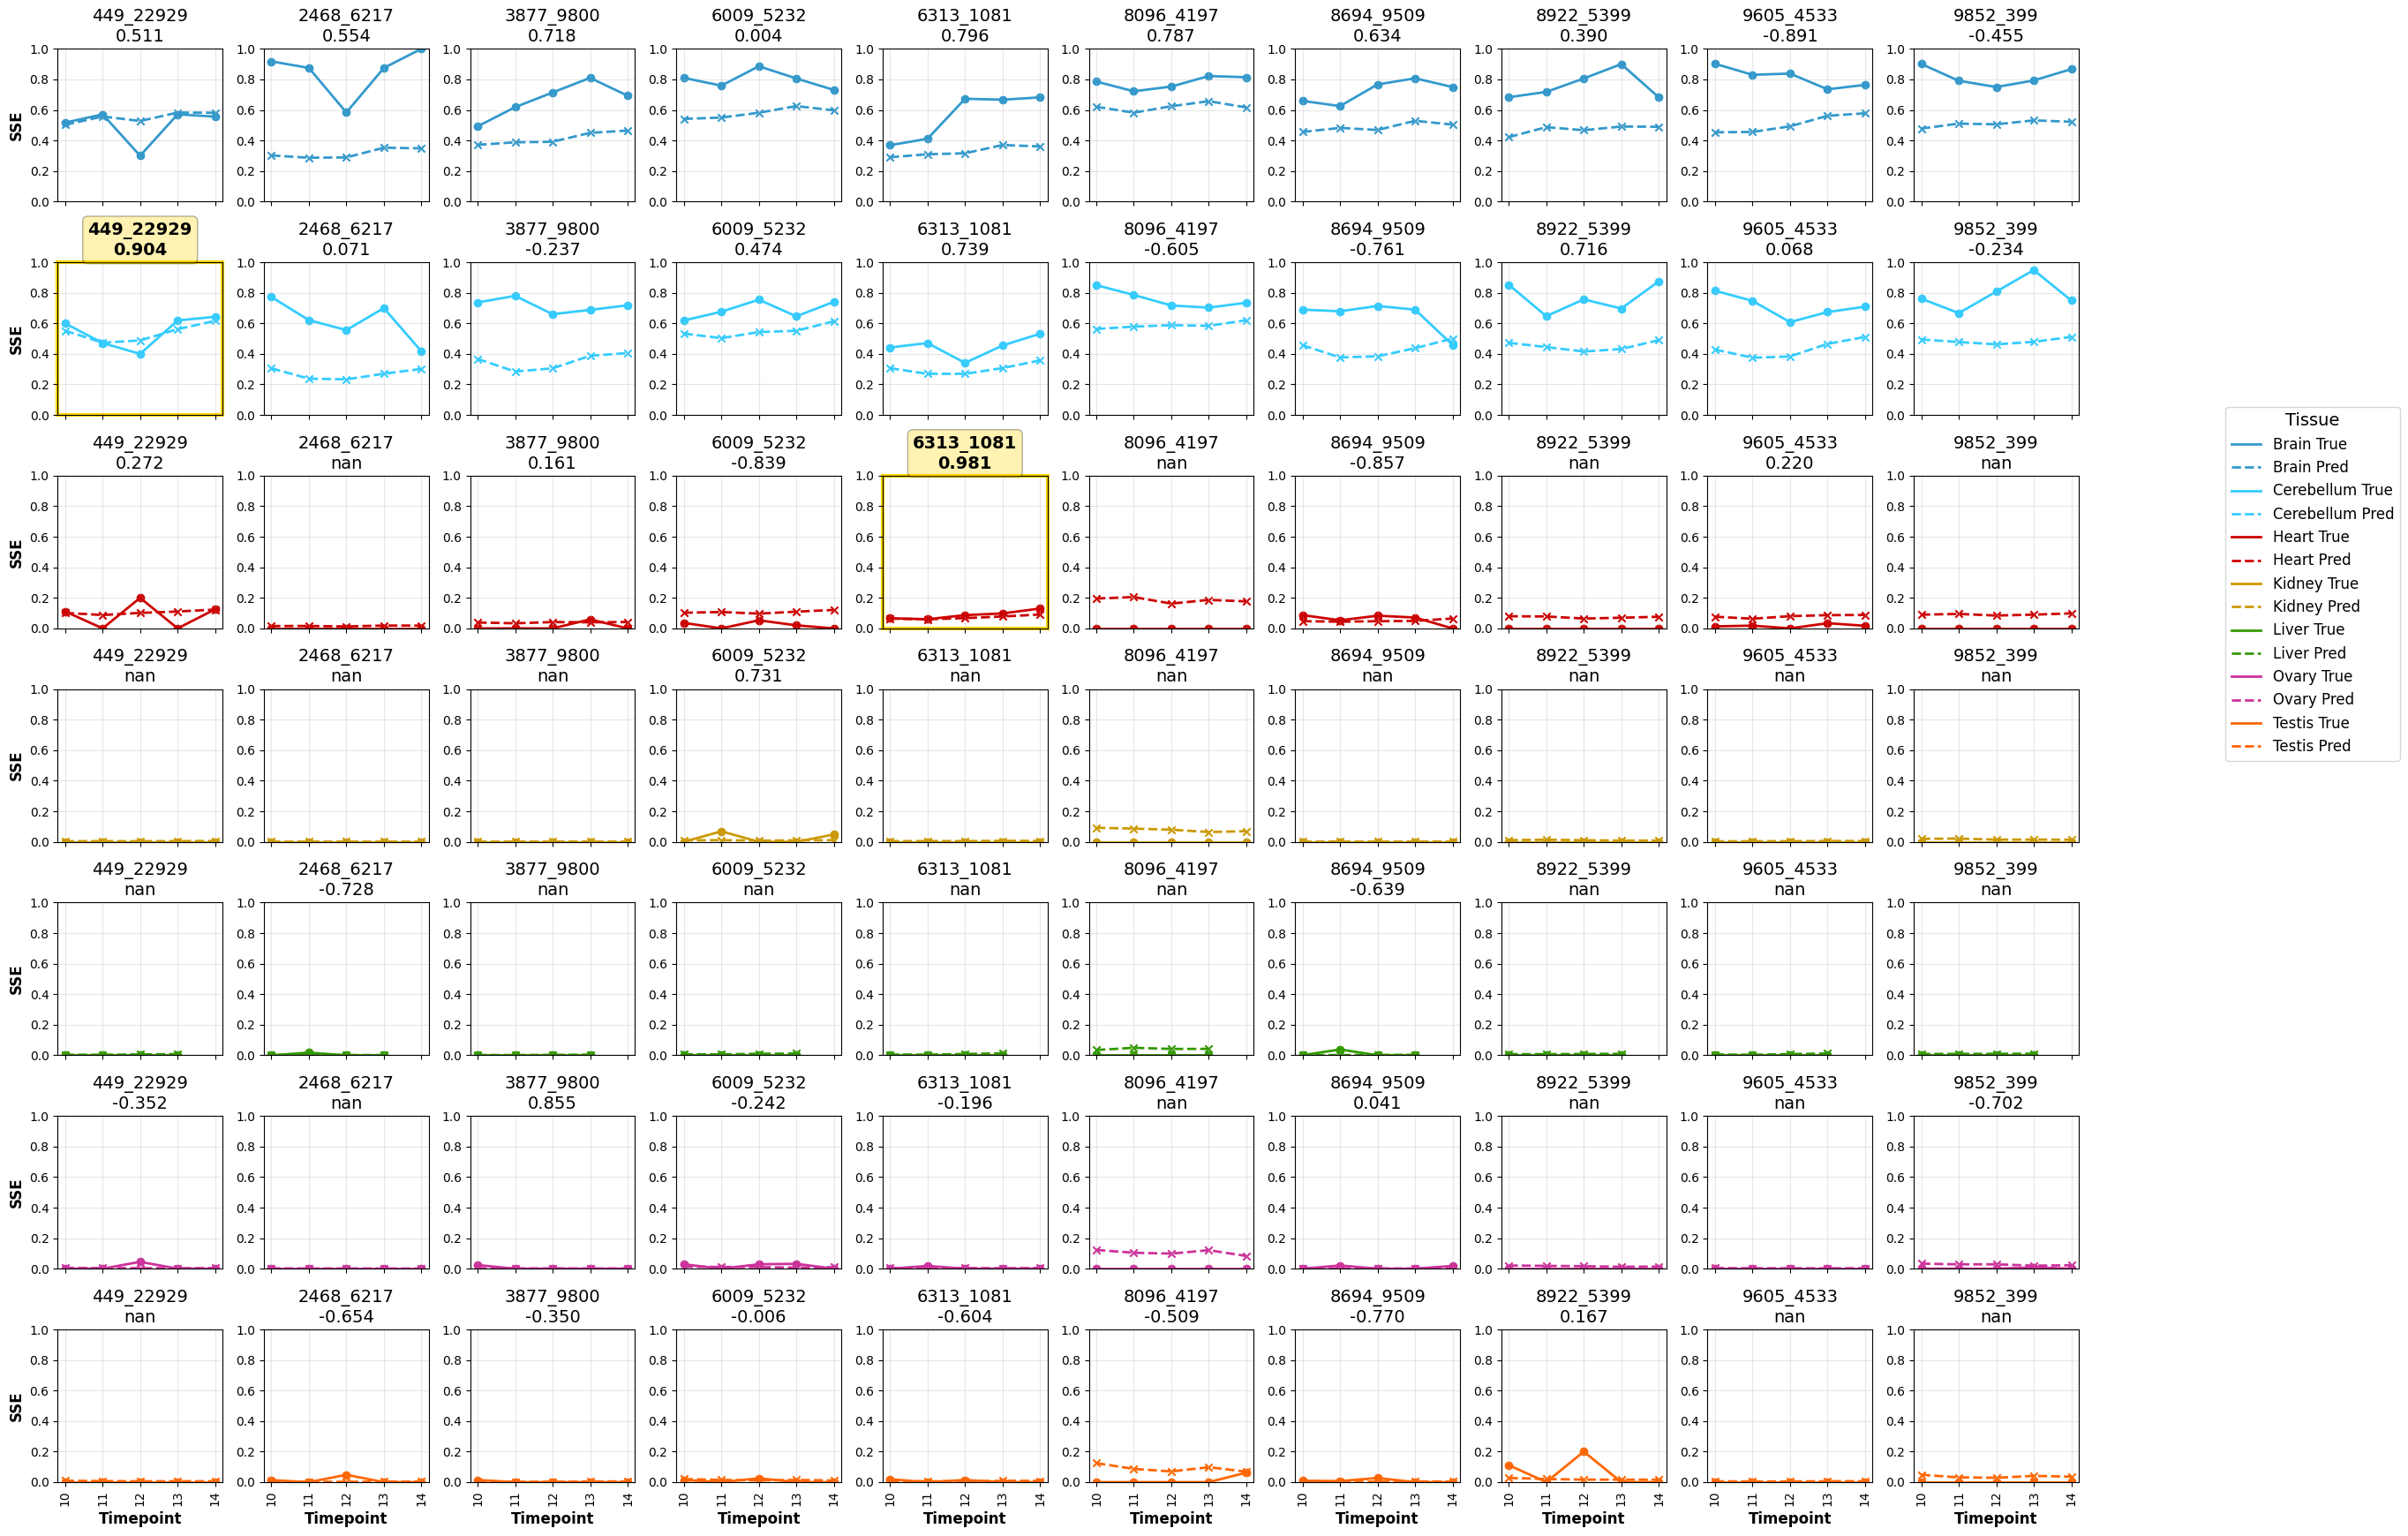

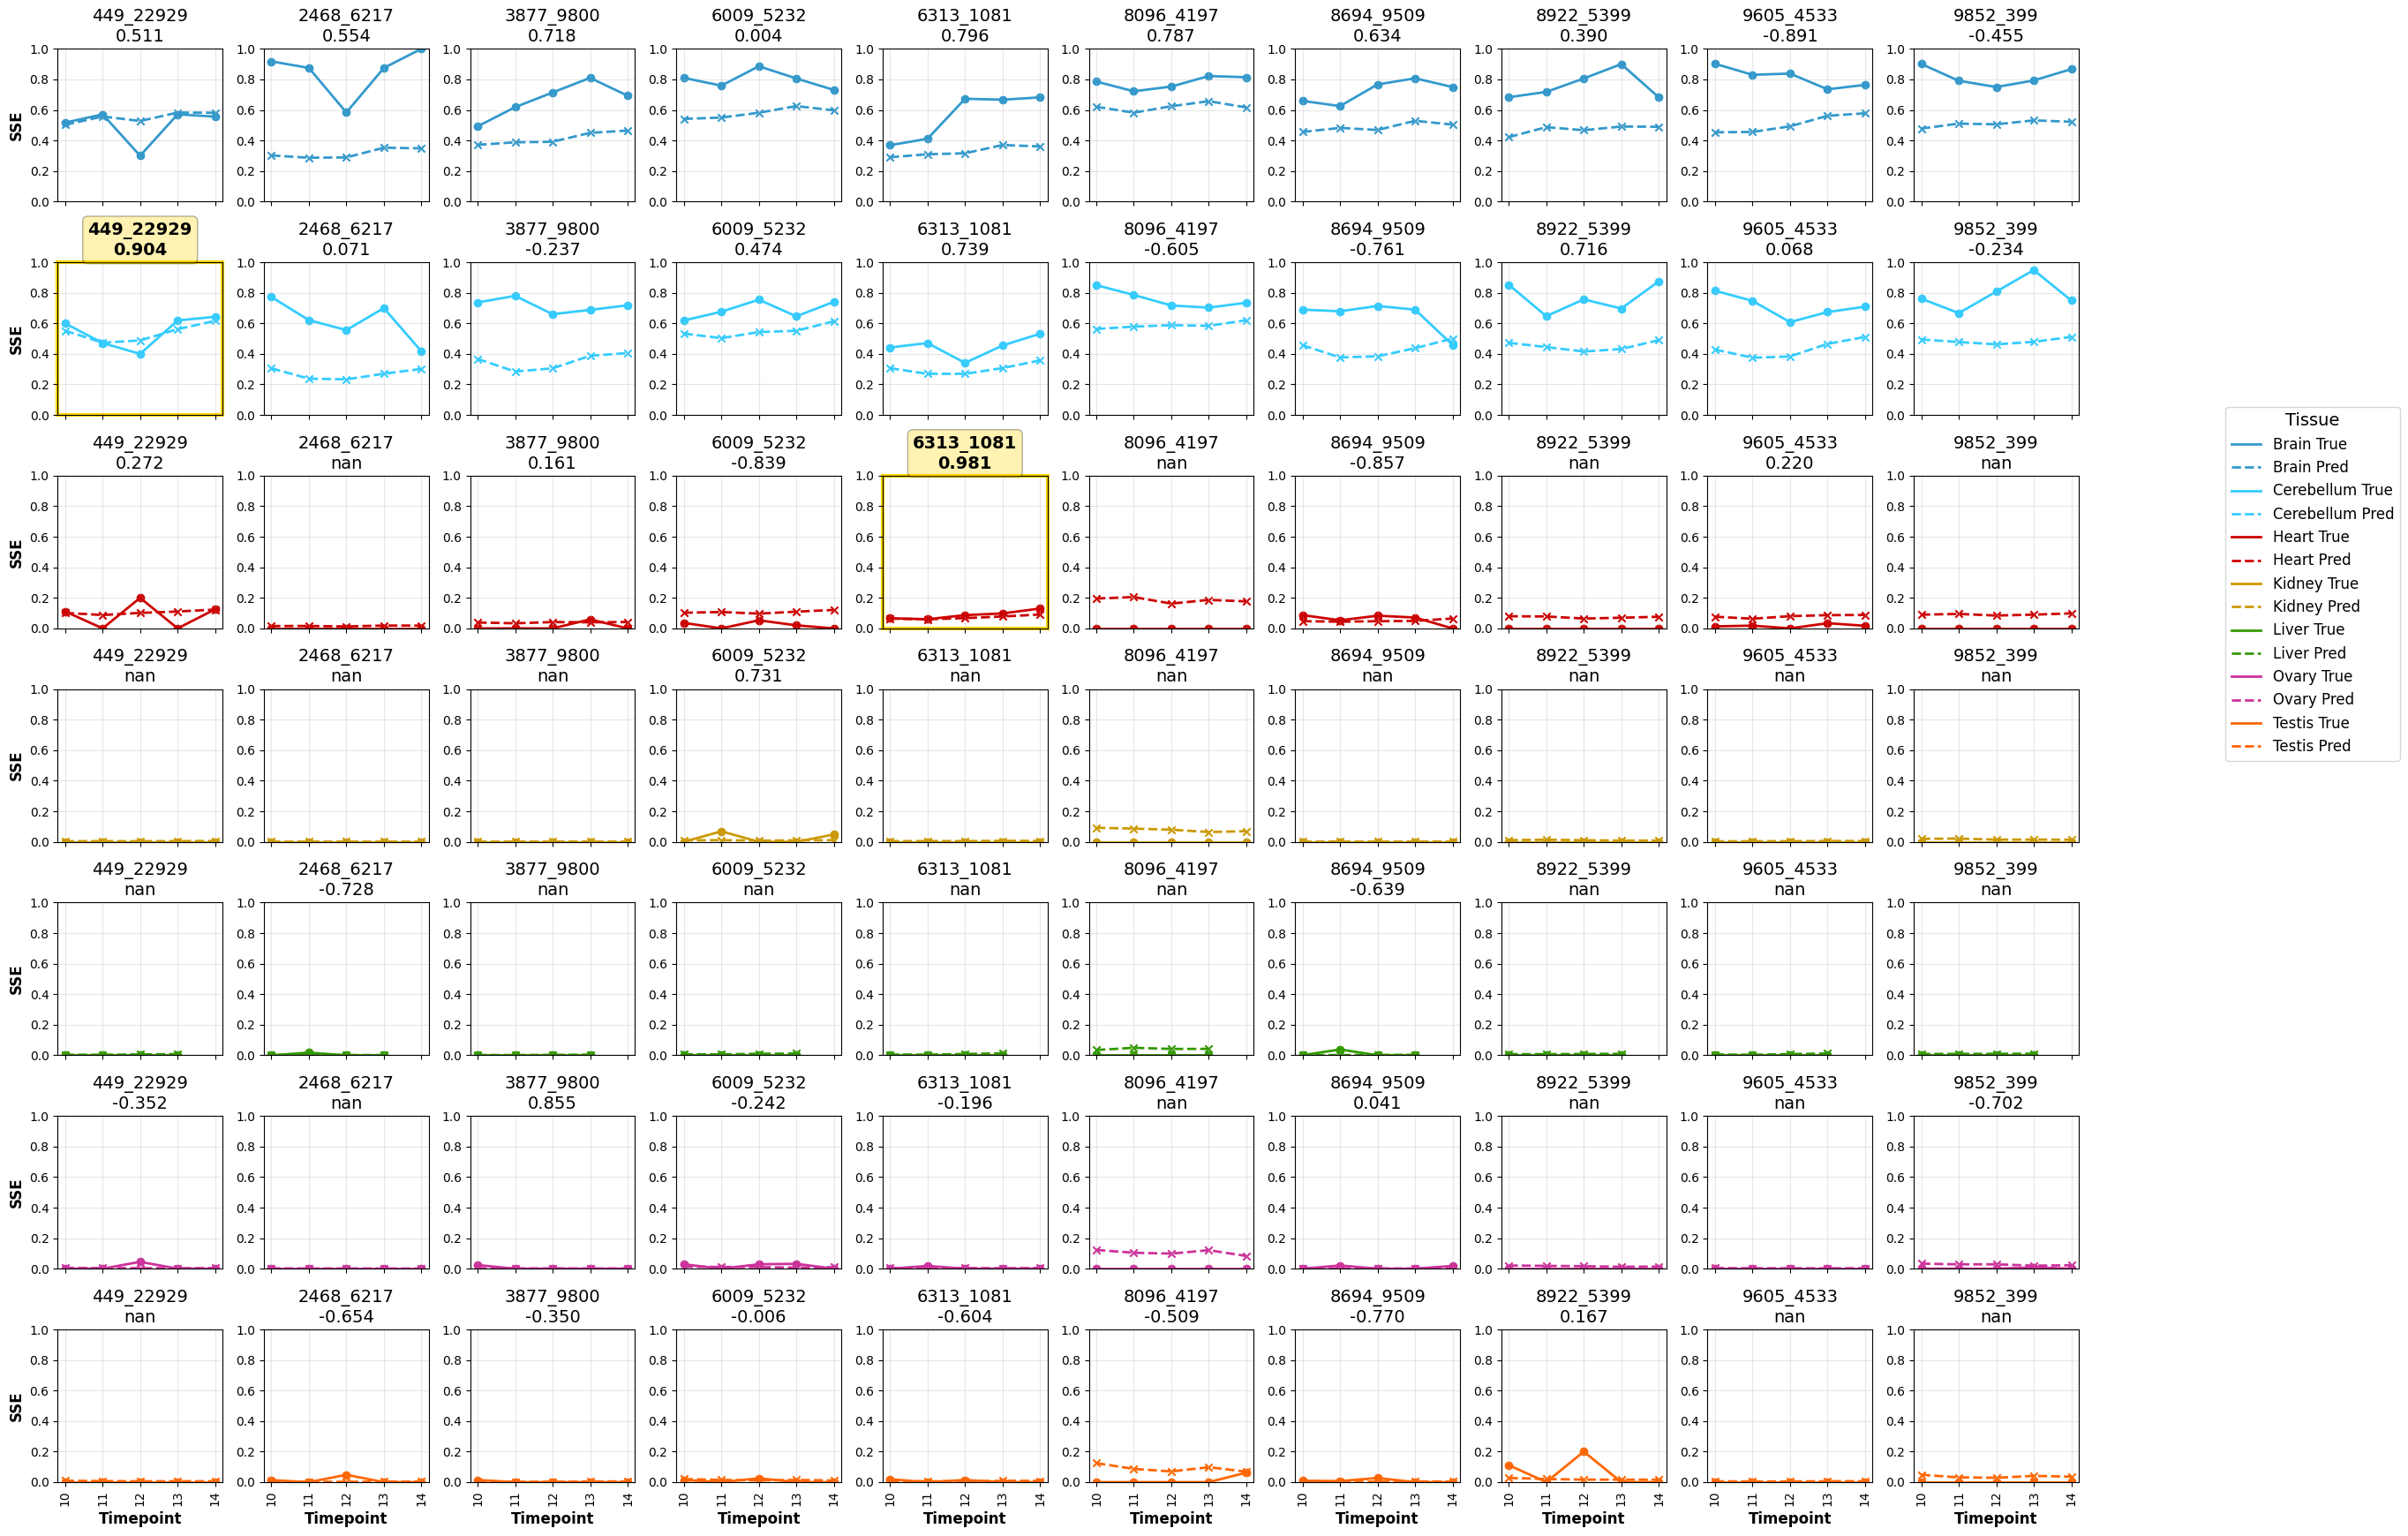

In [78]:
plot_sse_timeseries(plot_df, tissue_colors)

### Timecourse dynamics

In [89]:
final_df = pd.read_csv(os.path.join(model_dir, "predictions", "merged_predictions.csv.gz"), compression="gzip")
final_df

,organism,species_id,sample_idx,batch_idx,batch_sample_idx,genome_id,gene_id,chromosome,window_start,window_end,...,true_usage,pred_usage,condition_idx,condition_name,tissue,timepoint,num_conditions,num_timepoints,num_tissues,site_correlation
0,human,0,1,0,1,human_GRCh37,hum.10118,11,26353869,26363869,...,0.000,0.532887,0,Brain_10,Brain,10,7,5,5,0.720610
1,human,0,1,0,1,human_GRCh37,hum.10118,11,26353869,26363869,...,1.000,0.598788,0,Brain_10,Brain,10,6,4,3,0.695021
2,human,0,1,0,1,human_GRCh37,hum.10118,11,26353869,26363869,...,0.000,0.568621,0,Brain_10,Brain,10,3,3,2,0.564227
3,human,0,2,0,2,human_GRCh37,hum.10118,11,26453869,26463869,...,1.000,0.624229,0,Brain_10,Brain,10,6,3,3,0.860284
4,human,0,3,0,3,human_GRCh37,hum.10118,11,26463869,26473869,...,1.000,0.509882,0,Brain_10,Brain,10,5,3,3,0.776435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999163,mouse,1,9921,155,4,mouse_GRCm38,mou.33620,4,156176058,156186058,...,0.333,0.610169,36,Testis_14,Testis,14,33,5,7,0.148302
999164,mouse,1,9921,155,4,mouse_GRCm38,mou.33620,4,156176058,156186058,...,0.600,0.579669,36,Testis_14,Testis,14,34,5,7,0.358225
999165,mouse,1,9921,155,4,mouse_GRCm38,mou.33620,4,156176058,156186058,...,0.000,0.516082,36,Testis_14,Testis,14,25,5,6,0.199701
999166,mouse,1,9922,155,5,mouse_GRCm38,mou.33620,4,156186058,156196058,...,0.600,0.592504,36,Testis_14,Testis,14,34,5,7,0.071768


I will use definitio of developmentally dynamic sites from Mazin et al. There, to categorise the exons, the authors used a multi-step computational approach::

1. **Spline Approximation**: using cubic splines to approximate how PSI depends on developmental age (the logarithm of days from conception).
2. **Interpolation**: PSI values were interpolated into 1,000 evenly distributed age points, and the "PSI change" was calculated between each consecutive point.
3. **Statistical Calculation**: Four statistics were derived for each exon:  
    ◦ `up`: The sum of all positive PSI changes.  
    ◦ `down`: The absolute value of the sum of all negative PSI changes.  
    ◦ `up_timing`: The weighted average age of the positive changes (sum of positive changes multiplied by age, then divided by the total "up" value).  
    ◦ `down_timing`: The weighted average age of the negative changes (absolute sum of negative changes multiplied by age, then divided by the total "down" value).

Exons were assigned to one of the four classes based on the ratio of positive changes to the total change (`up/(up+down)`).  
  • **Down**: Assigned if the ratio is less than 0.3.  
  • **Up**: Assigned if the ratio is greater than 0.7.  
  • **Up–Down**: For exons with a ratio between 0.3 and 0.7, if `up_timing`<`down_timing`.  
  • **Down–Up**: For exons with a ratio between 0.3 and 0.7, if u`p_timing`>`down_timing`.  

Up and down patterns are the most prevalent, representing between 59% and 95% of all devAS exons depending on the species. Notably, up exons tend to have more highly conserved intronic sequences and a higher proportion of frame-preserving segments, suggesting they are more likely to be functionally relevant than down exons.

In [ ]:
# Function to clasify splice sites into categories based on the dynamics of their usage across timepoints
# up: 
# down

## Other stuff

In [17]:
import os
import pandas as pd
dir = "/home/elek/sds/sd17d003/Anamaria/alphagenome_pytorch/adult_mouse_human_10kb/predictions_finetune_model_splice_heads_warmup_wdecay/"
fn = "splice_site_predictions_all.csv.gz"
df = pd.read_csv(os.path.join(dir, fn))
df.value_counts('label')

label
0    16002
2    15358
1    14962
3    14894
Name: count, dtype: int64

In [18]:
df_mouse = df[df['organism'] == 'mouse']

In [25]:
import glob

per_batch_dir = os.path.join(dir, "per_batch")
org = "mouse"
class_idx = 0

files = sorted(glob.glob(f"{per_batch_dir}/auprcvec_{org}_class*_batch*.npz"))

# Grep for batch 302
files = [f for f in files if "batch302" in f]
files

['/home/elek/sds/sd17d003/Anamaria/alphagenome_pytorch/adult_mouse_human_10kb/predictions_finetune_model_splice_heads_warmup_wdecay/per_batch/auprcvec_mouse_class0_batch302.npz',
 '/home/elek/sds/sd17d003/Anamaria/alphagenome_pytorch/adult_mouse_human_10kb/predictions_finetune_model_splice_heads_warmup_wdecay/per_batch/auprcvec_mouse_class1_batch302.npz',
 '/home/elek/sds/sd17d003/Anamaria/alphagenome_pytorch/adult_mouse_human_10kb/predictions_finetune_model_splice_heads_warmup_wdecay/per_batch/auprcvec_mouse_class2_batch302.npz',
 '/home/elek/sds/sd17d003/Anamaria/alphagenome_pytorch/adult_mouse_human_10kb/predictions_finetune_model_splice_heads_warmup_wdecay/per_batch/auprcvec_mouse_class3_batch302.npz',
 '/home/elek/sds/sd17d003/Anamaria/alphagenome_pytorch/adult_mouse_human_10kb/predictions_finetune_model_splice_heads_warmup_wdecay/per_batch/auprcvec_mouse_class4_batch302.npz']

In [40]:
import numpy as np

trues = {}
preds = {}
for fn in files:
    arr = np.load(fn)
    class_idx = int(fn.split('_')[-2].replace('class', ''))
    trues[class_idx] = arr['y_true']
    preds[class_idx] = arr['y_score']

# make array of predicted probabilities for each class
preds_array = np.zeros((len(trues[0]), len(trues)))
for class_idx in trues:
    preds_array[:, class_idx] = preds[class_idx]

# get predicted class as the one with highest predicted probability
predicted_classes = np.argmax(preds_array, axis=1)

# make one hot encoding of true classes
true_classes = np.zeros((len(trues[0])))
true_classes
for class_idx in trues:
    true_classes[trues[class_idx] == 1] = class_idx


# count number of true classes
print("True class:")
for class_idx in trues.keys():
    count = np.sum(true_classes == class_idx)
    print(f"{class_idx}: {count} samples")

# count number of predicted classes
print("\nPredicted class:")
for class_idx in trues.keys():
    count = np.sum(predicted_classes == class_idx)
    print(f"{class_idx}: {count} samples")

True class:
0: 75 samples
1: 73 samples
2: 0 samples
3: 0 samples
4: 327532 samples

Predicted class:
0: 24 samples
1: 28 samples
2: 3 samples
3: 3 samples
4: 327622 samples
